## COMPARATIVE ANALYSIS OF PNEUMONIA DETECTION FROM CHEST X-RAYS

The dataset was obtained from kaggle: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia and contained 3 folders known as train, test and val. The train and val folders were merged together for better portioning i.e 80:20

## Import all libraries

In [47]:
# import necessary libraries
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from PIL import Image
from tensorflow import keras
from matplotlib import rcParams
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers
%matplotlib inline

# Import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Load the dataset

In [2]:
#Display folder content

print(os.listdir("chest_xray"))

#Load paths from folders

data_dir = Path('chest_xray')

train_dir = data_dir/'train'

test_dir = data_dir/'test'

['test', 'train']


In [3]:
#Base hyperparameters for the models

batch_size = 32
img_height = 224
img_width = 224

# Case 1: Proposed Model

## Pre-processing and Data Augmentation

In [4]:
# Pre-processing and Data augmentation using Image Data Generator
datagen_train = ImageDataGenerator(
        vertical_flip=True, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split = 0.2)

# 
datagen_test = ImageDataGenerator(rescale = 1./255)

In [5]:
# Fit the training set
train_ds = datagen_train.flow_from_directory(train_dir,
                                            target_size = (img_height, img_width),
                                            batch_size = batch_size,
                                            subset = 'training',
                                            class_mode = 'binary')

# Split validation sample
val_ds = datagen_train.flow_from_directory(train_dir,
                                            target_size = (img_height, img_width),
                                            batch_size = batch_size,
                                            subset = 'validation',
                                            class_mode = 'binary')

# Fit the test set
test_ds = datagen_test.flow_from_directory(test_dir,
                                            target_size = (img_height, img_width),
                                            batch_size = batch_size,
                                            shuffle = False,
                                            class_mode = 'binary')

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
# Class names
train_dir = data_dir/'train'
class_names = os.listdir(train_dir)
print(class_names)

['NORMAL', 'PNEUMONIA']


In [6]:
#Inspect the dataset

def inspect_dataset(X):
    
    normal = X/'NORMAL'
    pneumonia = X/'PNEUMONIA'


    norm = normal.glob('*.jpeg')
    pneum = pneumonia.glob('*.jpeg')
    
    #Create empty list for training dataset and labels
    data_train = []
    label_train = []

    for img in norm:
        data_train.append(img)
        label_train.append('NORMAL')
    for img in pneum:
        data_train.append(img)
        label_train.append('PNEUMONIA')

    train_df=pd.DataFrame(data_train)
    train_df.columns=['images']
    train_df['labels']=label_train
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    
    #Return the train_dataframe
    return train_df

In [7]:
#Callback the function
data_inspect = inspect_dataset(train_dir)

#Check shape of the training dataset
data_inspect.shape

(5232, 2)

In [8]:
#Check value counts of the training dataset

data_inspect['labels'].value_counts()

PNEUMONIA    3883
NORMAL       1349
Name: labels, dtype: int64

## Visualize the dataset samples

#### Training Dataset

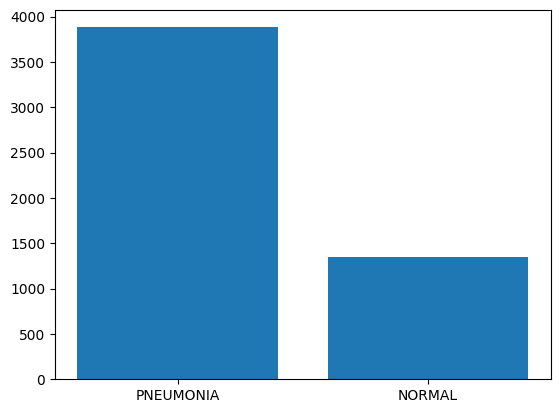

In [9]:
#Problem of imbalance in class hence, there's a need to balance the classes for the model to give accurate predictions

plt.bar(data_inspect['labels'].value_counts().index, data_inspect['labels'].value_counts().values)
plt.show();

#### Test Dataset

In [10]:
#Callback the function
test = inspect_dataset(test_dir)

#Check shape of the training dataset
test.shape

(624, 2)

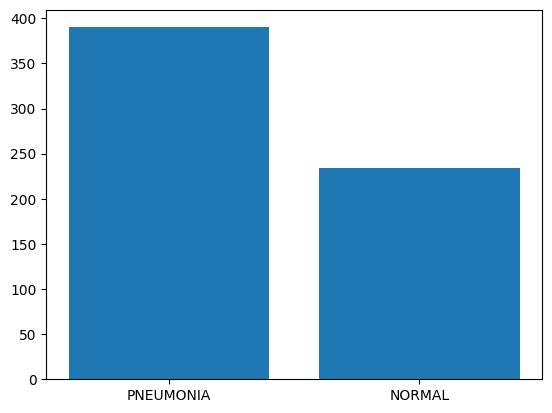

In [11]:
#Problem of imbalance in class hence, there's a need to balance the classes for the model to give accurate predictions

plt.bar(test['labels'].value_counts().index, test['labels'].value_counts().values)
plt.show();

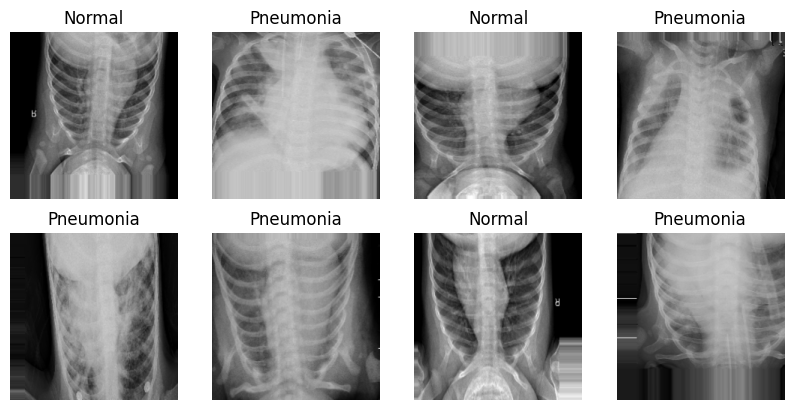

In [12]:
# Recall class_names
class_names = ['Normal', 'Pneumonia']

#Recall test image generator used earlier during pre-processing
image_batch, labels_batch = next(train_ds) 

# Show images with class names
plt.figure(figsize=(10,10))
for img in range(0,8): # Display 8 images
    plt.subplot(4,4, img+1)
    plt.imshow(image_batch[img])
    
    #Attach class_names as label
    label = class_names[int(labels_batch[img])]
    plt.title(label)
    plt.axis('off')
    
#Print images
plt.show()

## Build the model (Constructor stage)

Base hyperparameters used:

    * No of Convolutional blocks = 4
    * Optimizer = Adam
    * Learning Rate = 0.001
    * Batch size = 32
    * No of epochs = 20
    * Patience = 3
    * 2 Dropouts = 0.20

Others include:

    * Kernel_size = (3,3)
    * Filters = 32, 64, 128, 256
    * Pool_size = (2,2)

In [12]:
#EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#Build the model
model = Sequential([
    #Create each Convolutional layers
    layers.Conv2D(filters=32,kernel_size=(3,3),input_shape=(img_height, img_width, 3),activation = 'relu',padding = 'same'),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    layers.Dropout(0.20),
    
    #Create the flatten
    layers.Flatten(),

    #Create required fully connected layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.20),

    #Create product output
    layers.Dense(1, activation = 'sigmoid')
    ])

## Compile the model (Compilation stage)

In [13]:
# Compile the model
model_metrics = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss= 'binary_crossentropy', metrics = model_metrics)

In [14]:
# Model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       2

## Training and evaluation of the model (Training stage)

In [15]:
#Train and evaluate the model

epochs=20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[callback])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
#epochs_range = range(epochs)

Epoch 1/20
131/131 [==============================] - 451s 3s/step - loss: 0.4256 - accuracy: 0.8070 - precision: 0.8545 - recall: 0.8919 - val_loss: 0.2826 - val_accuracy: 0.8718 - val_precision: 0.9397 - val_recall: 0.8840
Epoch 2/20
131/131 [==============================] - 481s 4s/step - loss: 0.3284 - accuracy: 0.8603 - precision: 0.9031 - recall: 0.9092 - val_loss: 0.2608 - val_accuracy: 0.8756 - val_precision: 0.9295 - val_recall: 0.9008
Epoch 3/20
131/131 [==============================] - 496s 4s/step - loss: 0.2835 - accuracy: 0.8749 - precision: 0.9230 - recall: 0.9070 - val_loss: 0.2733 - val_accuracy: 0.8804 - val_precision: 0.9417 - val_recall: 0.8943
Epoch 4/20
131/131 [==============================] - 484s 4s/step - loss: 0.2817 - accuracy: 0.8818 - precision: 0.9296 - recall: 0.9096 - val_loss: 0.2804 - val_accuracy: 0.8593 - val_precision: 0.8907 - val_recall: 0.9240
Epoch 5/20
131/131 [==============================] - 481s 4s/step - loss: 0.2663 - accuracy: 0.8856

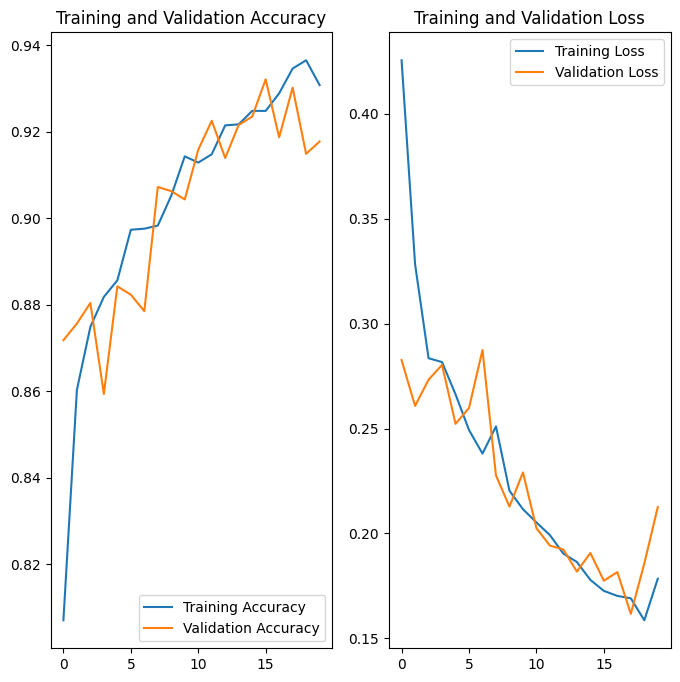

In [16]:
epochs_range = range(epochs)
# Plot a training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')

# Plot a training and validation loss/
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Test the model (Make predictions)

In [17]:
# Assign a label to the test classes

test_labels = test_ds.classes

In [19]:
# Make Predictions

y_pred = model.predict(test_ds)
y_pred

20/20 [==============================] - 16s 742ms/step


array([[1.61313474e-01],
       [1.90328479e-01],
       [7.68223405e-02],
       [2.07833797e-01],
       [7.61217996e-02],
       [1.19403929e-01],
       [1.40986517e-01],
       [5.67744263e-02],
       [9.99906287e-02],
       [8.48397762e-02],
       [7.09464699e-02],
       [1.35783166e-01],
       [1.52185291e-01],
       [1.33343741e-01],
       [1.62666842e-01],
       [6.45357445e-02],
       [9.32821393e-01],
       [8.40933397e-02],
       [4.02375869e-02],
       [9.91940349e-02],
       [3.45838010e-01],
       [5.93508817e-02],
       [1.15702838e-01],
       [1.05393924e-01],
       [2.50889987e-01],
       [3.74962986e-02],
       [2.70161945e-02],
       [8.97172540e-02],
       [1.42656356e-01],
       [9.69865471e-02],
       [1.00228213e-01],
       [2.79605165e-02],
       [1.29606098e-01],
       [2.30895337e-02],
       [6.02457896e-02],
       [1.34092808e-01],
       [4.35708556e-03],
       [5.08334517e-01],
       [6.69322759e-02],
       [5.13461744e-03],


In [20]:
# flatten the prediction
y_pred = np.round(y_pred).flatten()

## Visualise the results

In [21]:
# Print the classification report

print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       234
           1       0.92      0.93      0.93       390

    accuracy                           0.91       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



<Figure size 6000x6000 with 0 Axes>

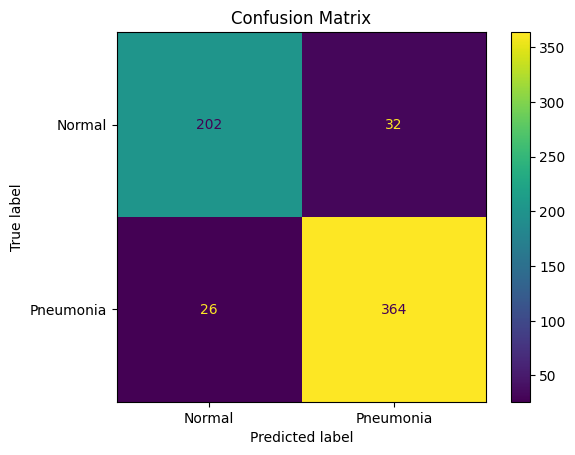

In [22]:
# Print the confusion matrix
plt.figure(dpi=200, figsize=(30,30))
cm = confusion_matrix(test_labels,y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
display.plot()
plt.title('Confusion Matrix')
plt.show()

# Case 2: Effect of Hyperparameter tuning such as Convolutional layers and Optimizers

### 2.1: Effect of Convolutional layers

## 3 Convolutional Layers

Base hyperparameters used:

    * No of Convolutional blocks = 3
    * Optimizer = Adam
    * Learning Rate = 0.001
    * Batch size = 32
    * No of epochs = 20
    * Patience = 3
    * 2 Dropouts = 0.20

Others include:

    * Kernel_size = (3,3)
    * Filters = 32, 64, 128
    * Pool_size = (2,2)

## Build the Model using the same conditions

In [10]:
#EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#Build the model
model_1 = Sequential([
    #Create each Convolutional layers
    layers.Conv2D(filters=32,kernel_size=(3,3),input_shape=(img_height, img_width, 3),activation = 'relu',padding = 'same'),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    layers.Dropout(0.20),
    
    #Create the flatten
    layers.Flatten(),

    #Create required fully connected layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.20),

    #Create product output
    layers.Dense(1, activation = 'sigmoid')
    ])

## Compile the model

In [11]:
# Compile the model
model_metrics = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]

optimizer = Adam(learning_rate=0.001)
model_1.compile(optimizer=optimizer, loss= 'binary_crossentropy', metrics = model_metrics)

In [12]:
# Model summary

model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 56, 56, 128)      

## Train and evaluate the model

In [13]:
#Train and evaluate the model

epochs=20
history2 = model_1.fit(train_ds, validation_data = val_ds, epochs=epochs, callbacks=[callback])
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs_range = range(epochs)

Epoch 1/20
131/131 [==============================] - 437s 3s/step - loss: 0.5501 - accuracy: 0.7655 - precision: 0.8086 - recall: 0.8960 - val_loss: 0.3368 - val_accuracy: 0.8364 - val_precision: 0.9138 - val_recall: 0.8608
Epoch 2/20
131/131 [==============================] - 492s 4s/step - loss: 0.3150 - accuracy: 0.8586 - precision: 0.9132 - recall: 0.8944 - val_loss: 0.2965 - val_accuracy: 0.8459 - val_precision: 0.8639 - val_recall: 0.9407
Epoch 3/20
131/131 [==============================] - 487s 4s/step - loss: 0.2990 - accuracy: 0.8596 - precision: 0.9083 - recall: 0.9018 - val_loss: 0.2972 - val_accuracy: 0.8727 - val_precision: 0.9586 - val_recall: 0.8660
Epoch 4/20
131/131 [==============================] - 542s 4s/step - loss: 0.2912 - accuracy: 0.8725 - precision: 0.9151 - recall: 0.9128 - val_loss: 0.2788 - val_accuracy: 0.8727 - val_precision: 0.9159 - val_recall: 0.9124
Epoch 5/20
131/131 [==============================] - 582s 4s/step - loss: 0.2559 - accuracy: 0.8935

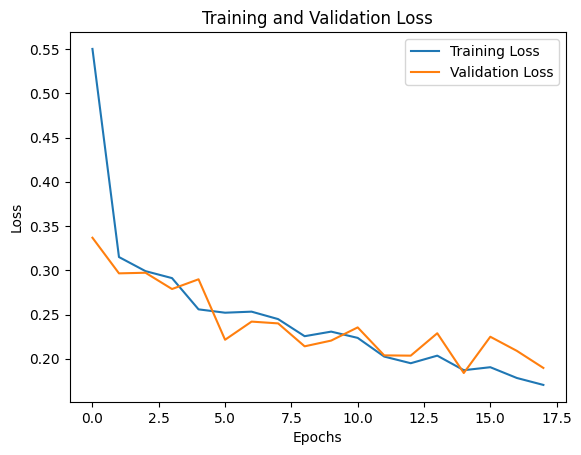

In [14]:
## checking for overfitting
# Plot of training loss against validation loss
#Plots the training loss as a line with label "Training Loss".
plt.plot(history2.history['loss'], label='Training Loss')
#Plots the validation loss as a line with label "Validation Loss".
plt.plot(history2.history['val_loss'], label='Validation Loss')
#Sets the title of the plot to "Training and Validation Loss".
plt.title('Training and Validation Loss')
#Assign x-label
plt.xlabel('Epochs')
#Assign y-label
plt.ylabel('Loss')
#Display legends of with the labels
plt.legend()
#Display the plot
plt.show()

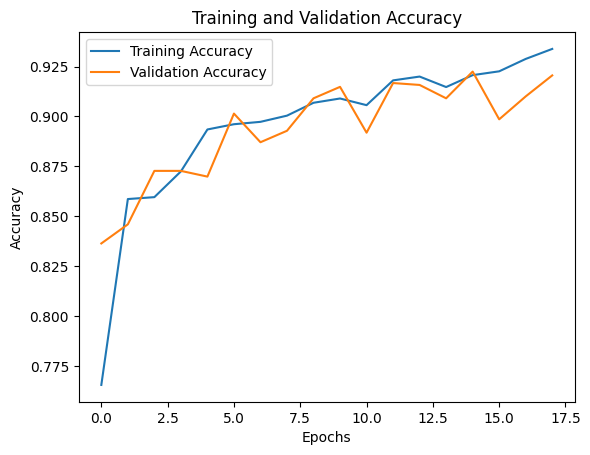

In [15]:
# Plot a training and validation accuracy
#Plots the training accuracy as a line with label "Training Accuracy".
plt.plot(history2.history['accuracy'], label='Training Accuracy')
#Plots the validation accuracy as a line with label "Validation Accuracy".
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
#Sets the title of the plot to "Training and Validation Accuracy".
plt.title('Training and Validation Accuracy')
#Assign x-label
plt.xlabel('Epochs')
#Assign y-label
plt.ylabel('Accuracy')
#Display legends of with the labels
plt.legend()
#Display the plot
plt.show()

### Make Predictions

In [17]:
new_test_labels = test_ds.classes
new_y_pred = model_1.predict(test_ds)
#imbal_y_pred

20/20 [==============================] - 16s 722ms/step


In [18]:
# Flatten the predicted value

new_y_pred = np.round(new_y_pred).flatten()

In [20]:
# Print the classification report

print(classification_report(new_test_labels, new_y_pred))

              precision    recall  f1-score   support

           0       0.91      0.59      0.72       234
           1       0.80      0.97      0.87       390

    accuracy                           0.83       624
   macro avg       0.86      0.78      0.80       624
weighted avg       0.84      0.83      0.82       624



<Figure size 6000x6000 with 0 Axes>

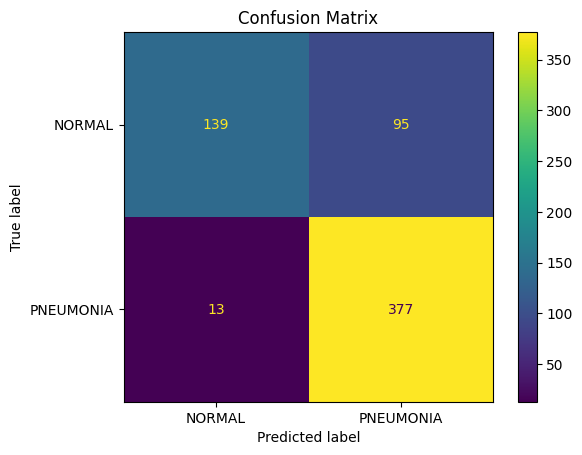

In [22]:
# Print the confusion matrix
plt.figure(dpi=200, figsize=(30,30))
cm = confusion_matrix(new_test_labels, new_y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
display.plot()
plt.title('Confusion Matrix')
plt.show()

## 5 Convolutional Layers

Base hyperparameters used:

    * No of Convolutional blocks = 5
    * Optimizer = Adam
    * Learning Rate = 0.001
    * Batch size = 32
    * No of epochs = 20
    * Patience = 3
    * 2 Dropouts = 0.20

Others include:

    * Kernel_size = (3,3)
    * Filters = 32, 64, 2*128, 256
    * Pool_size = (2,2)

In [24]:
#EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#Build the model
model_7 = Sequential([
    #Create each Convolutional layers
    layers.Conv2D(filters=32,kernel_size=(3,3),input_shape=(img_height, img_width, 3),activation = 'relu',padding = 'same'),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    layers.Dropout(0.20),
    
    #Create the flatten
    layers.Flatten(),

    #Create required fully connected layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.20),

    #Create product output
    layers.Dense(1, activation = 'sigmoid')
    ])

In [25]:
# Compile the model
model_metrics = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]

optimizer = Adam(learning_rate=0.001)
model_7.compile(optimizer=optimizer, loss= 'binary_crossentropy', metrics = model_metrics)

In [26]:
# Model summary

model_7.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 56, 56, 128)      

In [27]:
#Train and evaluate the model

epochs=20
history_7 = model_7.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[callback])
acc = history_7.history['accuracy']
val_acc = history_7.history['val_accuracy']
loss = history_7.history['loss']
val_loss = history_7.history['val_loss']
#epochs_range = range(epochs)

Epoch 1/20
131/131 [==============================] - 543s 4s/step - loss: 0.4544 - accuracy: 0.7588 - precision: 0.7753 - recall: 0.9504 - val_loss: 0.3268 - val_accuracy: 0.8287 - val_precision: 0.9163 - val_recall: 0.8466
Epoch 2/20
131/131 [==============================] - 560s 4s/step - loss: 0.3184 - accuracy: 0.8550 - precision: 0.9027 - recall: 0.9018 - val_loss: 0.2784 - val_accuracy: 0.8584 - val_precision: 0.9153 - val_recall: 0.8918
Epoch 3/20
131/131 [==============================] - 623s 5s/step - loss: 0.3006 - accuracy: 0.8677 - precision: 0.9178 - recall: 0.9025 - val_loss: 0.2877 - val_accuracy: 0.8785 - val_precision: 0.9209 - val_recall: 0.9149
Epoch 4/20
131/131 [==============================] - 614s 5s/step - loss: 0.2801 - accuracy: 0.8849 - precision: 0.9243 - recall: 0.9202 - val_loss: 0.2566 - val_accuracy: 0.8794 - val_precision: 0.9288 - val_recall: 0.9072
Epoch 5/20
131/131 [==============================] - 578s 4s/step - loss: 0.2609 - accuracy: 0.8913

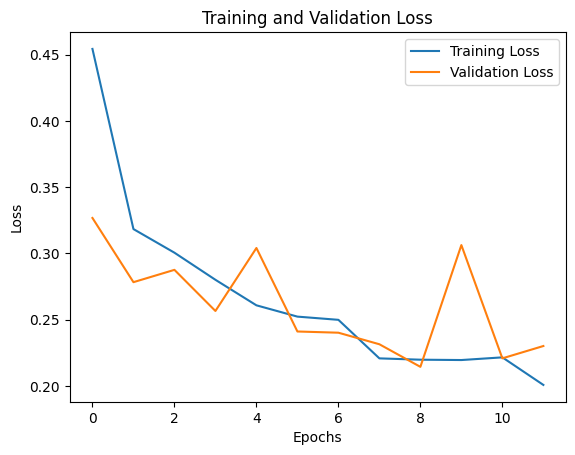

In [28]:
## checking for overfitting
# Plot of training loss against validation loss
#Plots the training loss as a line with label "Training Loss".
plt.plot(history_7.history['loss'], label='Training Loss')
#Plots the validation loss as a line with label "Validation Loss".
plt.plot(history_7.history['val_loss'], label='Validation Loss')
#Sets the title of the plot to "Training and Validation Loss".
plt.title('Training and Validation Loss')
#Assign x-label
plt.xlabel('Epochs')
#Assign y-label
plt.ylabel('Loss')
#Display legends of with the labels
plt.legend()
#Display the plot
plt.show()

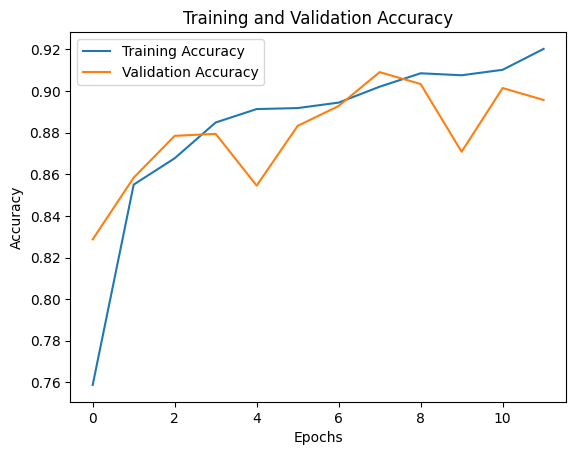

In [29]:
# Plot a training and validation accuracy
#Plots the training accuracy as a line with label "Training Accuracy".
plt.plot(history_7.history['accuracy'], label='Training Accuracy')
#Plots the validation accuracy as a line with label "Validation Accuracy".
plt.plot(history_7.history['val_accuracy'], label='Validation Accuracy')
#Sets the title of the plot to "Training and Validation Accuracy".
plt.title('Training and Validation Accuracy')
#Assign x-label
plt.xlabel('Epochs')
#Assign y-label
plt.ylabel('Accuracy')
#Display legends of with the labels
plt.legend()
#Display the plot
plt.show()

### Make Predictions

In [31]:
y_pred_7 = model_7.predict(test_ds)

# flatten the prediction
y_pred_7 = np.round(y_pred_7).flatten()

20/20 [==============================] - 18s 861ms/step


### Visualise the results

In [33]:
# Print the classification report

print(classification_report(new_test_labels, y_pred_7))

              precision    recall  f1-score   support

           0       0.89      0.58      0.70       234
           1       0.79      0.96      0.87       390

    accuracy                           0.81       624
   macro avg       0.84      0.77      0.78       624
weighted avg       0.83      0.81      0.80       624



<Figure size 6000x6000 with 0 Axes>

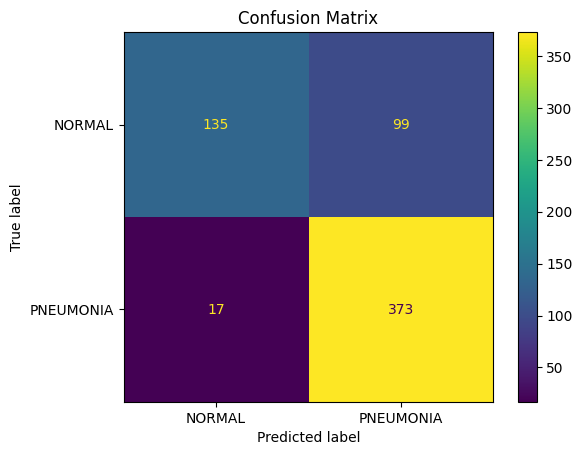

In [34]:
# Print the confusion matrix
plt.figure(dpi=200, figsize=(30,30))
cm = confusion_matrix(new_test_labels,y_pred_7)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
display.plot()
plt.title('Confusion Matrix')
plt.show()

## 6 Convolutional Layers

hyperparameters used:

    * No of Convolutional blocks = 6
    * Optimizer = Adam
    * Learning Rate = 0.001
    * Batch size = 32
    * No of epochs = 20
    * Patience = 3
    * 2 Dropouts = 0.20

Others include:

    * Kernel_size = (3,3)
    * Filters = 32, 2*64, 2*128, 256
    * Pool_size = (2,2)

In [7]:
#EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#Build the model
model_8 = Sequential([
    #Create each Convolutional layers
    layers.Conv2D(filters=32,kernel_size=(3,3),input_shape=(img_height, img_width, 3),activation = 'relu',padding = 'same'),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    layers.Dropout(0.20),
    
    #Create the flatten
    layers.Flatten(),

    #Create required fully connected layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.20),

    #Create product output
    layers.Dense(1, activation = 'sigmoid')
    ])

In [8]:
# Compile the model
model_metrics = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]

optimizer = Adam(learning_rate=0.001)
model_8.compile(optimizer=optimizer, loss= 'binary_crossentropy', metrics = model_metrics)

In [9]:
# Model summary

model_8.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 56, 56, 128)      

In [11]:
#Train and evaluate the model

epochs=20
history8 = model_8.fit(train_ds, validation_data = val_ds, epochs=epochs, callbacks=[callback])
acc = history8.history['accuracy']
val_acc = history8.history['val_accuracy']
loss = history8.history['loss']
val_loss = history8.history['val_loss']
#epochs_range = range(epochs)

Epoch 1/20
131/131 [==============================] - 406s 3s/step - loss: 0.4689 - accuracy: 0.7404 - precision: 0.7440 - recall: 0.9913 - val_loss: 0.4562 - val_accuracy: 0.7856 - val_precision: 0.8217 - val_recall: 0.9085
Epoch 2/20
131/131 [==============================] - 400s 3s/step - loss: 0.3535 - accuracy: 0.8314 - precision: 0.8491 - recall: 0.9398 - val_loss: 0.3188 - val_accuracy: 0.8565 - val_precision: 0.8972 - val_recall: 0.9111
Epoch 3/20
131/131 [==============================] - 436s 3s/step - loss: 0.3329 - accuracy: 0.8610 - precision: 0.8893 - recall: 0.9282 - val_loss: 0.3107 - val_accuracy: 0.8622 - val_precision: 0.8911 - val_recall: 0.9278
Epoch 4/20
131/131 [==============================] - 406s 3s/step - loss: 0.3281 - accuracy: 0.8694 - precision: 0.9038 - recall: 0.9221 - val_loss: 0.2911 - val_accuracy: 0.8900 - val_precision: 0.9472 - val_recall: 0.9021
Epoch 5/20
131/131 [==============================] - 414s 3s/step - loss: 0.3073 - accuracy: 0.8758

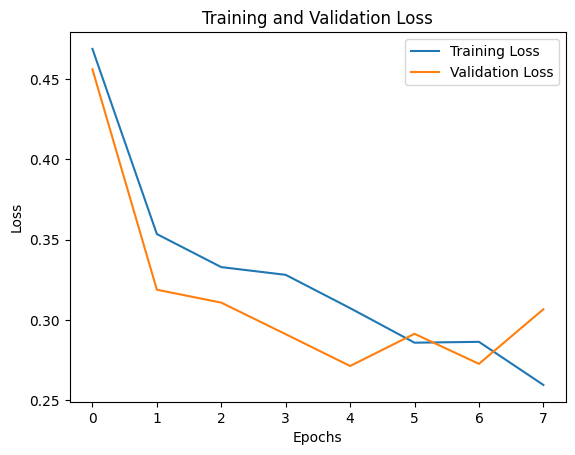

In [12]:
## checking for overfitting
# Plot of training loss against validation loss
#Plots the training loss as a line with label "Training Loss".
plt.plot(history8.history['loss'], label='Training Loss')
#Plots the validation loss as a line with label "Validation Loss".
plt.plot(history8.history['val_loss'], label='Validation Loss')
#Sets the title of the plot to "Training and Validation Loss".
plt.title('Training and Validation Loss')
#Assign x-label
plt.xlabel('Epochs')
#Assign y-label
plt.ylabel('Loss')
#Display legends of with the labels
plt.legend()
#Display the plot
plt.show()

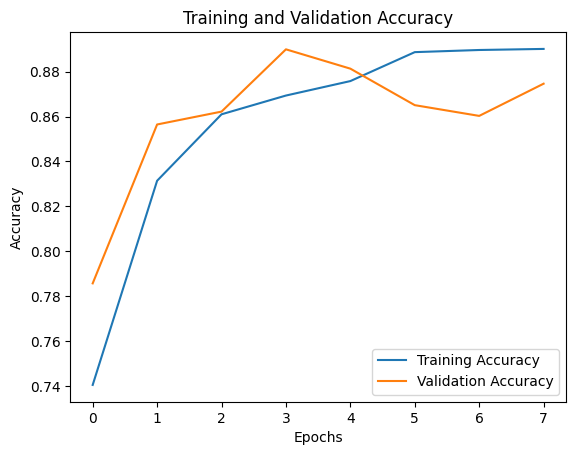

In [13]:
# Plot a training and validation accuracy
#Plots the training accuracy as a line with label "Training Accuracy".
plt.plot(history8.history['accuracy'], label='Training Accuracy')
#Plots the validation accuracy as a line with label "Validation Accuracy".
plt.plot(history8.history['val_accuracy'], label='Validation Accuracy')
#Sets the title of the plot to "Training and Validation Accuracy".
plt.title('Training and Validation Accuracy')
#Assign x-label
plt.xlabel('Epochs')
#Assign y-label
plt.ylabel('Accuracy')
#Display legends of with the labels
plt.legend()
#Display the plot
plt.show()

### Make Predictions

In [14]:
y_pred_8 = model_8.predict(test_ds)

# flatten the prediction
y_pred_8 = np.round(y_pred_8).flatten()

20/20 [==============================] - 17s 797ms/step


### Visualize the results

In [16]:
# Print the classification report

new_test_labels = test_ds.classes
print(classification_report(new_test_labels, y_pred_8))

              precision    recall  f1-score   support

           0       0.84      0.32      0.47       234
           1       0.70      0.96      0.81       390

    accuracy                           0.72       624
   macro avg       0.77      0.64      0.64       624
weighted avg       0.75      0.72      0.68       624



<Figure size 6000x6000 with 0 Axes>

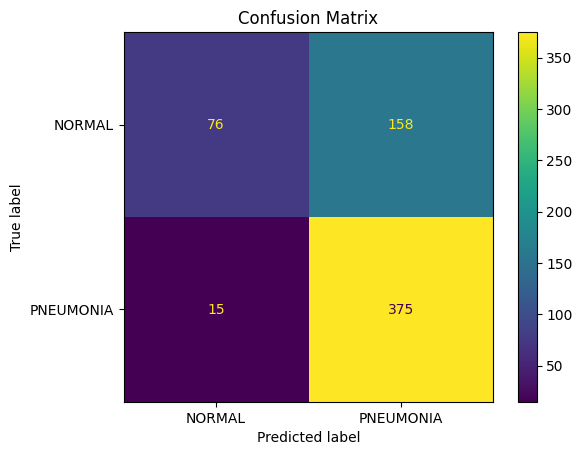

In [19]:
# Print the confusion matrix
plt.figure(dpi=200, figsize=(30,30))
cm = confusion_matrix(new_test_labels,y_pred_8)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
display.plot()
plt.title('Confusion Matrix')
plt.show()

In [52]:
# Create Main Title
Metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

# Other Title
Models = ['Proposed Model', 'Three ConV_Layers', 'Five ConV_Layers', 'Six ConV_Layers']

# Create Input Values
values = [[0.90, 0.90, 0.90, 0.91], [0.86, 0.78, 0.80, 0.83], [0.84, 0.77, 0.78, 0.81], [0.77, 0.64, 0.64, 0.72]]

# Transform to a dataframe
ConV_layers = pd.DataFrame(values, Models, Metrics)
ConV_layers

Precision  Recall  F1-Score  Accuracy
Proposed Model          0.90    0.90      0.90      0.91
Three ConV_Layers       0.86    0.78      0.80      0.83
Five ConV_Layers        0.84    0.77      0.78      0.81
Six ConV_Layers         0.77    0.64      0.64      0.72

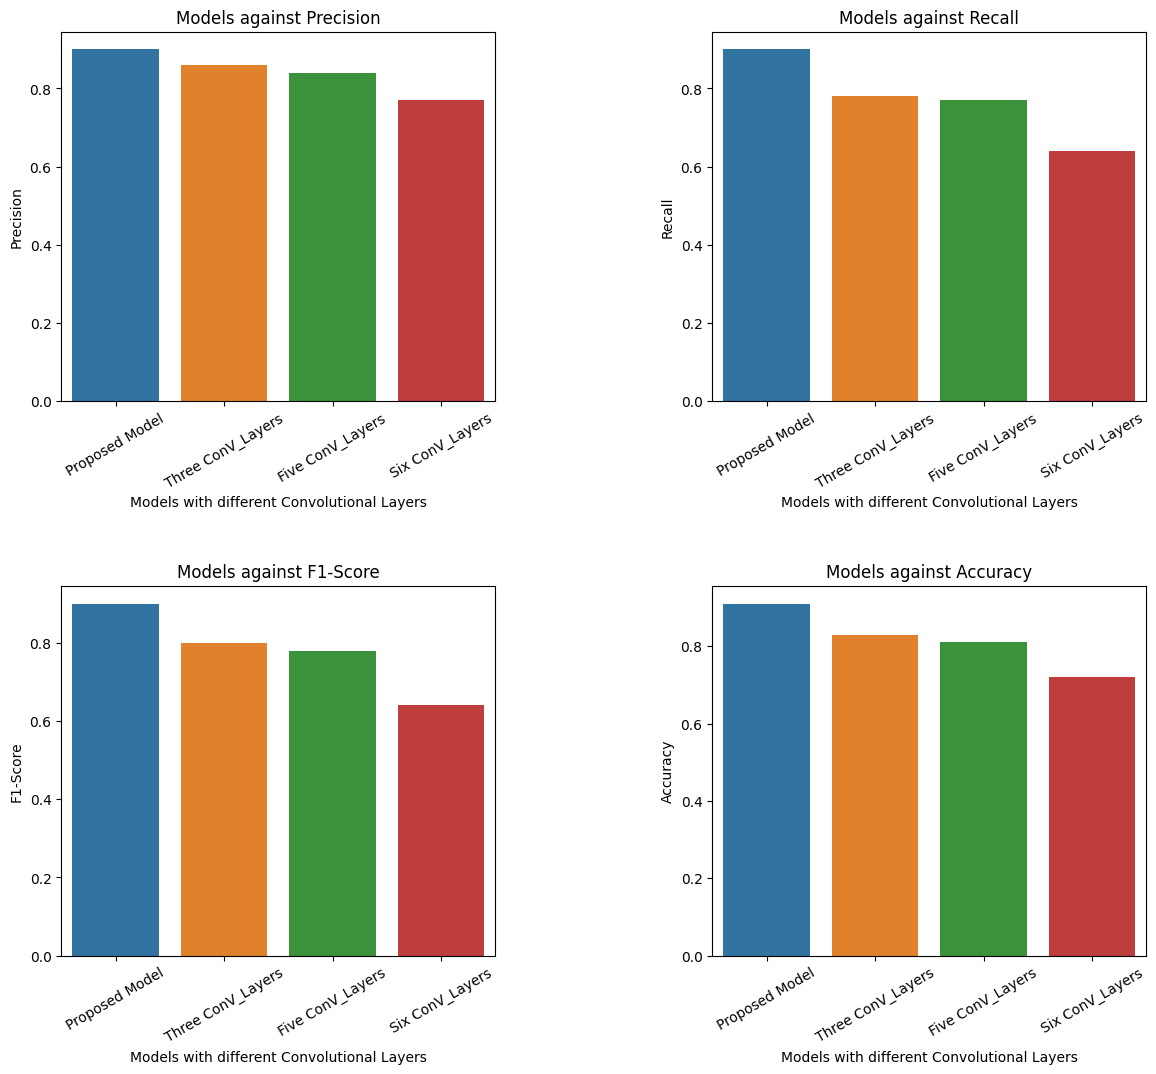

In [53]:
#Graph of Models against Evaluation Metrics
rcParams['figure.figsize'] = 14, 12

#subplot 1
plt.subplot(2,2,1)
#Create a plot of Models against Precision
sns.barplot(data=ConV_layers, y='Precision', x=Models)
plt.title('Models against Precision')
plt.xlabel('Models with different Convolutional Layers')
plt.ylabel('Precision')
plt.xticks(rotation=30);

#subplot 2
plt.subplot(2,2,2)
#Create a plot of Models against Recall
sns.barplot(data=ConV_layers, y='Recall', x=Models)
plt.title('Models against Recall')
plt.xlabel('Models with different Convolutional Layers')
plt.ylabel('Recall')
plt.xticks(rotation=30);

#subplot 3
plt.subplot(2,2,3)
#Create a plot of Models against F1-Score
sns.barplot(data=ConV_layers, y='F1-Score', x=Models)
plt.title('Models against F1-Score')
plt.xlabel('Models with different Convolutional Layers')
plt.ylabel('F1-Score')
plt.xticks(rotation=30);

#subplot 4
plt.subplot(2,2,4)
#Create a plot of Models against Accuracy
sns.barplot(data=ConV_layers, y='Accuracy', x=Models)
plt.title('Models against Accuracy')
plt.xlabel('Models with different Convolutional Layers')
plt.ylabel('Accuracy')
plt.xticks(rotation=30);

plt.subplots_adjust(wspace=0.50, 
                    hspace=0.5)

GitHub (2023). Prosper_Loan_Visualization/Part_I_Prosper_Exploratory_Analysis.ipynb at main · CalebNewton/Prosper_Loan_Visualization. Available online: https://github.com/CalebNewton/Prosper_Loan_Visualization/blob/main/Part_I_Prosper_Exploratory_Analysis.ipynb [Accessed 10 Sep. 2023].

### 2.2: Effect of Optimizers

## Stochastic Gradient Descent (SGD) Optimizer 

In [20]:
#EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#Build the model
model9 = Sequential([
    #Create each Convolutional layers
    layers.Conv2D(filters=32,kernel_size=(3,3),input_shape=(img_height, img_width, 3),activation = 'relu',padding = 'same'),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    layers.Dropout(0.20),
    
    #Create the flatten
    layers.Flatten(),

    #Create required fully connected layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.20),

    #Create product output
    layers.Dense(1, activation = 'sigmoid')
    ])

In [24]:
# Compile the model
model_metrics = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]

optimizer = SGD(learning_rate=0.001, momentum=0.9)
model9.compile(optimizer=optimizer, loss= 'binary_crossentropy', metrics = model_metrics)

In [25]:
# Model summary

model9.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 56, 56, 256)      

In [26]:
#Train and evaluate the model

epochs=20
history9 = model9.fit(train_ds, validation_data = val_ds, epochs=epochs, callbacks=[callback])
acc = history9.history['accuracy']
val_acc = history9.history['val_accuracy']
loss = history9.history['loss']
val_loss = history9.history['val_loss']

Epoch 1/20
131/131 [==============================] - 539s 4s/step - loss: 0.5650 - accuracy: 0.7423 - precision: 0.7429 - recall: 0.9981 - val_loss: 0.5691 - val_accuracy: 0.7388 - val_precision: 0.7725 - val_recall: 0.9188
Epoch 2/20
131/131 [==============================] - 591s 5s/step - loss: 0.5488 - accuracy: 0.7480 - precision: 0.7540 - recall: 0.9804 - val_loss: 0.5359 - val_accuracy: 0.7426 - val_precision: 0.7426 - val_recall: 1.0000
Epoch 3/20
131/131 [==============================] - 664s 5s/step - loss: 0.5164 - accuracy: 0.7626 - precision: 0.7663 - recall: 0.9784 - val_loss: 0.4745 - val_accuracy: 0.7837 - val_precision: 0.7841 - val_recall: 0.9781
Epoch 4/20
131/131 [==============================] - 622s 5s/step - loss: 0.4893 - accuracy: 0.7796 - precision: 0.7910 - recall: 0.9553 - val_loss: 0.4631 - val_accuracy: 0.7809 - val_precision: 0.7852 - val_recall: 0.9704
Epoch 5/20
131/131 [==============================] - 612s 5s/step - loss: 0.4937 - accuracy: 0.7755

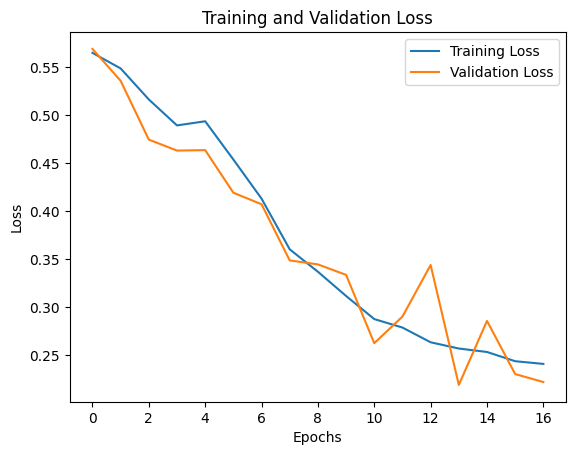

In [27]:
## checking for overfitting
# Plot of training loss against validation loss
#Plots the training loss as a line with label "Training Loss".
plt.plot(history9.history['loss'], label='Training Loss')
#Plots the validation loss as a line with label "Validation Loss".
plt.plot(history9.history['val_loss'], label='Validation Loss')
#Sets the title of the plot to "Training and Validation Loss".
plt.title('Training and Validation Loss')
#Assign x-label
plt.xlabel('Epochs')
#Assign y-label
plt.ylabel('Loss')
#Display legends of with the labels
plt.legend()
#Display the plot
plt.show()

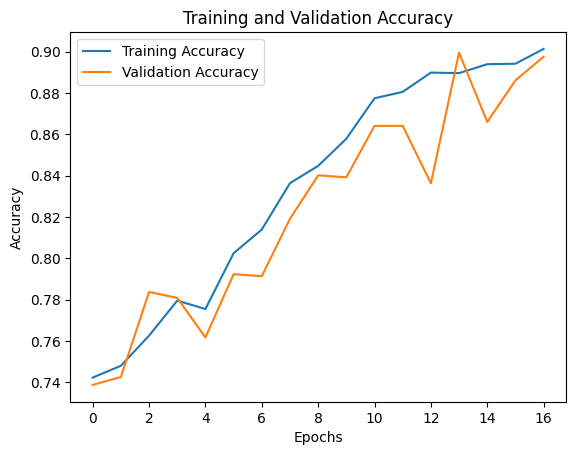

In [28]:
# Plot a training and validation accuracy
#Plots the training accuracy as a line with label "Training Accuracy".
plt.plot(history9.history['accuracy'], label='Training Accuracy')
#Plots the validation accuracy as a line with label "Validation Accuracy".
plt.plot(history9.history['val_accuracy'], label='Validation Accuracy')
#Sets the title of the plot to "Training and Validation Accuracy".
plt.title('Training and Validation Accuracy')
#Assign x-label
plt.xlabel('Epochs')
#Assign y-label
plt.ylabel('Accuracy')
#Display legends of with the labels
plt.legend()
#Display the plot
plt.show()

### Make Predictions

In [29]:
y_pred_9 = model9.predict(test_ds)

# flatten the prediction
y_pred_9 = np.round(y_pred_9).flatten()

20/20 [==============================] - 26s 1s/step


### Visualize the results

In [30]:
# Print the classification report

print(classification_report(new_test_labels, y_pred_9))

              precision    recall  f1-score   support

           0       0.91      0.59      0.72       234
           1       0.80      0.96      0.87       390

    accuracy                           0.82       624
   macro avg       0.85      0.78      0.79       624
weighted avg       0.84      0.82      0.81       624



<Figure size 6000x6000 with 0 Axes>

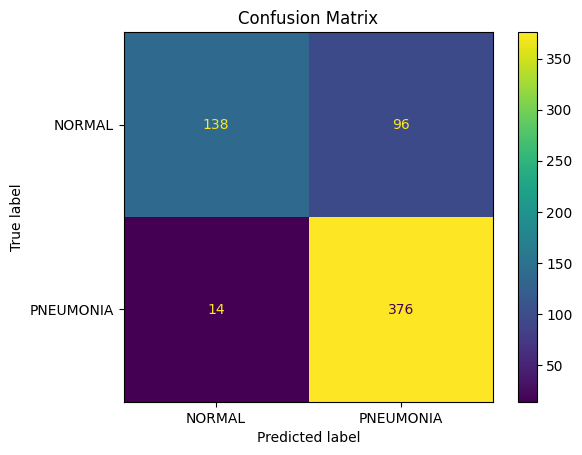

In [31]:
# Print the confusion matrix
plt.figure(dpi=200, figsize=(30,30))
cm = confusion_matrix(new_test_labels,y_pred_9)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
display.plot()
plt.title('Confusion Matrix')
plt.show()

## Adagrad Optimizer

In [7]:
#EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#Build the model
model10 = Sequential([
    #Create each Convolutional layers
    layers.Conv2D(filters=32,kernel_size=(3,3),input_shape=(img_height, img_width, 3),activation='relu',padding='same'),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    layers.Dropout(0.20),
    
    #Create the flatten
    layers.Flatten(),

    #Create required fully connected layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.20),

    #Create product output
    layers.Dense(1, activation = 'sigmoid')
    ])

In [8]:
# Compile the model
model_metrics = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]

optimizer = Adagrad(learning_rate=0.001)
model10.compile(optimizer=optimizer, loss= 'binary_crossentropy', metrics = model_metrics)

In [9]:
# Model summary

model10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       2

In [10]:
#Train and evaluate the model

epochs=20
history10 = model10.fit(train_ds, validation_data = val_ds, epochs=epochs, callbacks=[callback])
acc = history10.history['accuracy']
val_acc = history10.history['val_accuracy']
loss = history10.history['loss']
val_loss = history10.history['val_loss']

Epoch 1/20
131/131 [==============================] - 580s 4s/step - loss: 0.5799 - accuracy: 0.7397 - precision: 0.7423 - recall: 0.9945 - val_loss: 0.5597 - val_accuracy: 0.7426 - val_precision: 0.7426 - val_recall: 1.0000
Epoch 2/20
131/131 [==============================] - 586s 4s/step - loss: 0.5652 - accuracy: 0.7421 - precision: 0.7421 - recall: 1.0000 - val_loss: 0.5583 - val_accuracy: 0.7426 - val_precision: 0.7426 - val_recall: 1.0000
Epoch 3/20
131/131 [==============================] - 534s 4s/step - loss: 0.5530 - accuracy: 0.7428 - precision: 0.7435 - recall: 0.9974 - val_loss: 0.5319 - val_accuracy: 0.7426 - val_precision: 0.7426 - val_recall: 1.0000
Epoch 4/20
131/131 [==============================] - 577s 4s/step - loss: 0.5413 - accuracy: 0.7461 - precision: 0.7493 - recall: 0.9887 - val_loss: 0.5561 - val_accuracy: 0.7426 - val_precision: 0.7426 - val_recall: 1.0000
Epoch 5/20
131/131 [==============================] - 552s 4s/step - loss: 0.5327 - accuracy: 0.7533

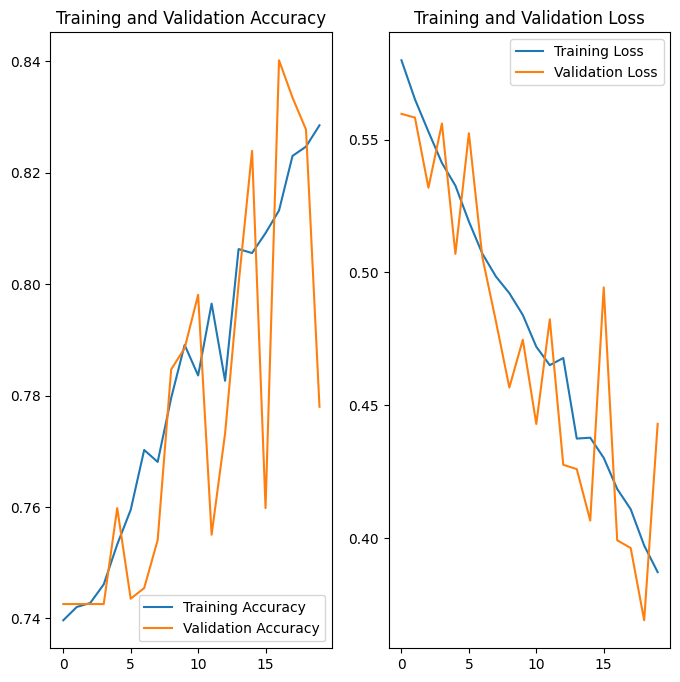

In [11]:
epochs_range = range(epochs)
# Plot a training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')

# Plot a training and validation loss/
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Make Predictions

In [13]:
new_test_labels = test_ds.classes
y_pred_10 = model10.predict(test_ds)

# flatten the prediction
y_pred_10 = np.round(y_pred_10).flatten()

20/20 [==============================] - 17s 799ms/step


### Visualize the result

In [14]:
# Print the classification report

print(classification_report(new_test_labels, y_pred_10))

              precision    recall  f1-score   support

           0       1.00      0.08      0.15       234
           1       0.64      1.00      0.78       390

    accuracy                           0.66       624
   macro avg       0.82      0.54      0.47       624
weighted avg       0.78      0.66      0.55       624



<Figure size 6000x6000 with 0 Axes>

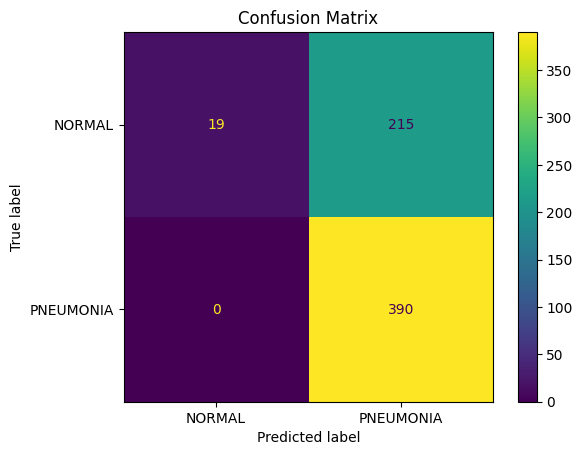

In [15]:
# Print the confusion matrix
plt.figure(dpi=200, figsize=(30,30))
cm = confusion_matrix(new_test_labels,y_pred_10)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
display.plot()
plt.title('Confusion Matrix')
plt.show()

## RMSprop Optimizer

In [16]:
#EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#Build the model
model11 = Sequential([
    #Create each Convolutional layers
    layers.Conv2D(filters=32,kernel_size=(3,3),input_shape=(img_height, img_width, 3),activation='relu',padding='same'),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu'),layers.MaxPooling2D(),
    layers.Dropout(0.20),
    
    #Create the flatten
    layers.Flatten(),

    #Create required fully connected layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.20),

    #Create product output
    layers.Dense(1, activation = 'sigmoid')
    ])

In [17]:
# Compile the model
model_metrics = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]

optimizer = RMSprop(learning_rate=0.001)
model11.compile(optimizer=optimizer, loss= 'binary_crossentropy', metrics = model_metrics)

In [18]:
# Model summary

model11.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 256)      

In [19]:
#Train and evaluate the model

epochs=20
history11 = model11.fit(train_ds, validation_data = val_ds, epochs=epochs, callbacks=[callback])
acc = history11.history['accuracy']
val_acc = history11.history['val_accuracy']
loss = history11.history['loss']
val_loss = history11.history['val_loss']

Epoch 1/20
131/131 [==============================] - 528s 4s/step - loss: 1.2373 - accuracy: 0.7521 - precision: 0.7920 - recall: 0.9031 - val_loss: 0.4149 - val_accuracy: 0.7646 - val_precision: 0.8764 - val_recall: 0.7951
Epoch 2/20
131/131 [==============================] - 538s 4s/step - loss: 0.4166 - accuracy: 0.7963 - precision: 0.8528 - recall: 0.8767 - val_loss: 0.3661 - val_accuracy: 0.8000 - val_precision: 0.9139 - val_recall: 0.8067
Epoch 3/20
131/131 [==============================] - 571s 4s/step - loss: 0.3657 - accuracy: 0.8290 - precision: 0.8811 - recall: 0.8896 - val_loss: 0.3237 - val_accuracy: 0.8488 - val_precision: 0.8892 - val_recall: 0.9098
Epoch 4/20
131/131 [==============================] - 559s 4s/step - loss: 0.3410 - accuracy: 0.8464 - precision: 0.8990 - recall: 0.8935 - val_loss: 0.4542 - val_accuracy: 0.7569 - val_precision: 0.7579 - val_recall: 0.9884
Epoch 5/20
131/131 [==============================] - 556s 4s/step - loss: 0.3106 - accuracy: 0.8706

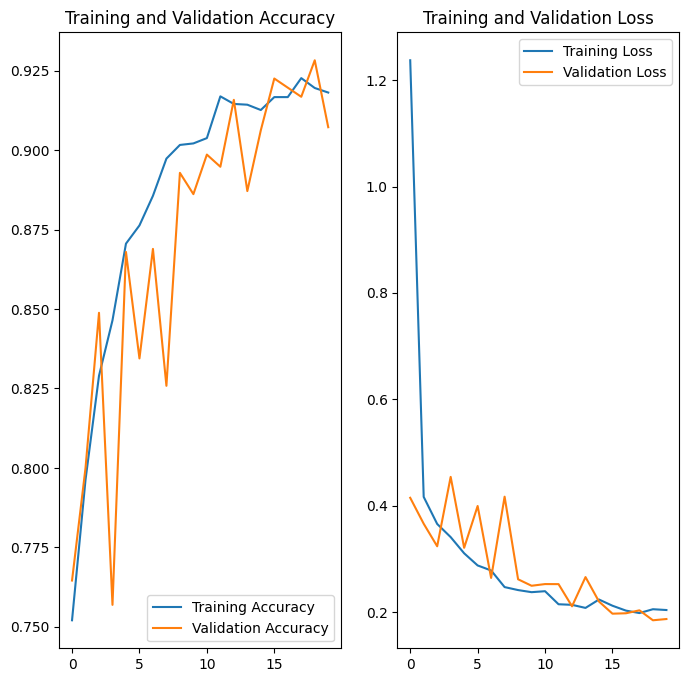

In [20]:
epochs_range = range(epochs)
# Plot a training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')

# Plot a training and validation loss/
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Make Predictions

In [21]:
y_pred_11 = model11.predict(test_ds)

# flatten the prediction
y_pred_11 = np.round(y_pred_11).flatten()

20/20 [==============================] - 24s 1s/step


### Visualize the results

In [22]:
# Print the classification report

print(classification_report(new_test_labels, y_pred_11))

              precision    recall  f1-score   support

           0       0.93      0.53      0.68       234
           1       0.78      0.97      0.86       390

    accuracy                           0.81       624
   macro avg       0.85      0.75      0.77       624
weighted avg       0.83      0.81      0.79       624



<Figure size 6000x6000 with 0 Axes>

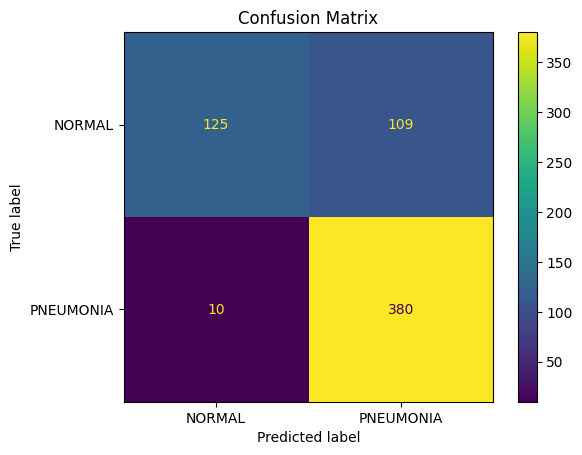

In [23]:
# Print the confusion matrix
plt.figure(dpi=200, figsize=(30,30))
cm = confusion_matrix(new_test_labels,y_pred_11)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
display.plot()
plt.title('Confusion Matrix')
plt.show()

In [48]:
# Create Main Title
Metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

# Other Title
Models = ['Proposed Model', 'SGD', 'Adagrad', 'RMSprop']

# Create Input Values
values = [[0.90, 0.90, 0.90, 0.91], [0.85, 0.78, 0.79, 0.82], [0.82, 0.54, 0.47, 0.66], [0.85, 0.75, 0.77, 0.81]]

# Transform to a dataframe
Optimizers = pd.DataFrame(values, Models, Metrics)
Optimizers

Precision  Recall  F1-Score  Accuracy
Proposed Model       0.90    0.90      0.90      0.91
SGD                  0.85    0.78      0.79      0.82
Adagrad              0.82    0.54      0.47      0.66
RMSprop              0.85    0.75      0.77      0.81

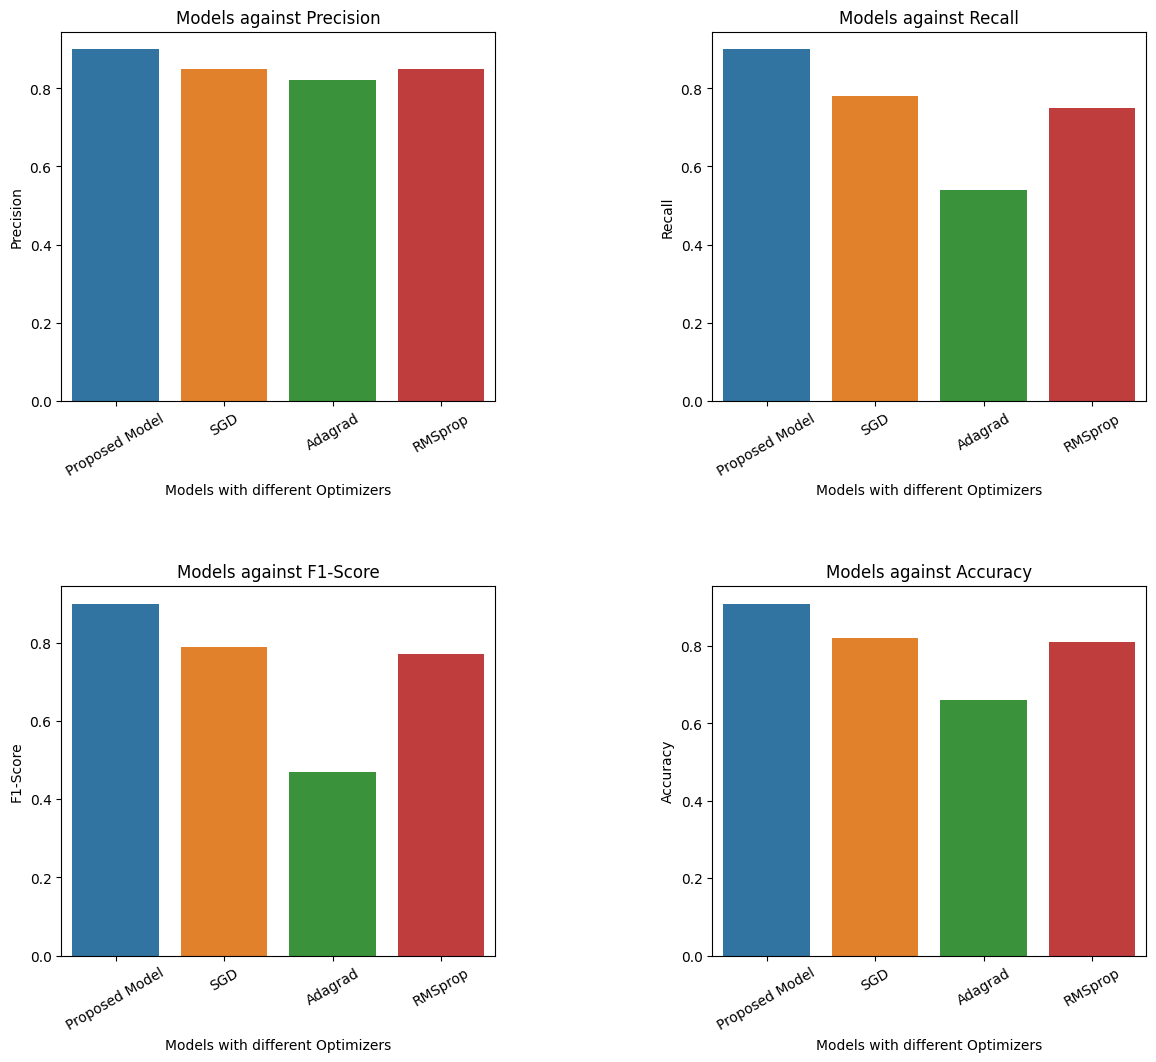

In [50]:
#Graph of Models against Evaluation Metrics
rcParams['figure.figsize'] = 14, 12

#subplot 1
plt.subplot(2,2,1)
#Create a plot of Models against Precision
sns.barplot(data=Optimizers, y='Precision', x=Models)
plt.title('Models against Precision')
plt.xlabel('Models with different Optimizers')
plt.ylabel('Precision')
plt.xticks(rotation=30);

#subplot 2
plt.subplot(2,2,2)
#Create a plot of Models against Recall
sns.barplot(data=Optimizers, y='Recall', x=Models)
plt.title('Models against Recall')
plt.xlabel('Models with different Optimizers')
plt.ylabel('Recall')
plt.xticks(rotation=30);

#subplot 3
plt.subplot(2,2,3)
#Create a plot of Models against F1-Score
sns.barplot(data=Optimizers, y='F1-Score', x=Models)
plt.title('Models against F1-Score')
plt.xlabel('Models with different Optimizers')
plt.ylabel('F1-Score')
plt.xticks(rotation=30);

#subplot 4
plt.subplot(2,2,4)
#Create a plot of Models against Accuracy
sns.barplot(data=Optimizers, y='Accuracy', x=Models)
plt.title('Models against Accuracy')
plt.xlabel('Models with different Optimizers')
plt.ylabel('Accuracy')
plt.xticks(rotation=30);

plt.subplots_adjust(wspace=0.50, 
                    hspace=0.5)

# Case 3: Comparing Pretrained Networks against the CNN model created

## MobileNetv2

In [13]:
# Split training sample

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size, 
    label_mode='int')

# Split validation sample

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size, 
    label_mode='int')

# Load the test sample

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, 
    image_size=(img_height, img_width),
    batch_size=batch_size, 
    label_mode='binary')

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


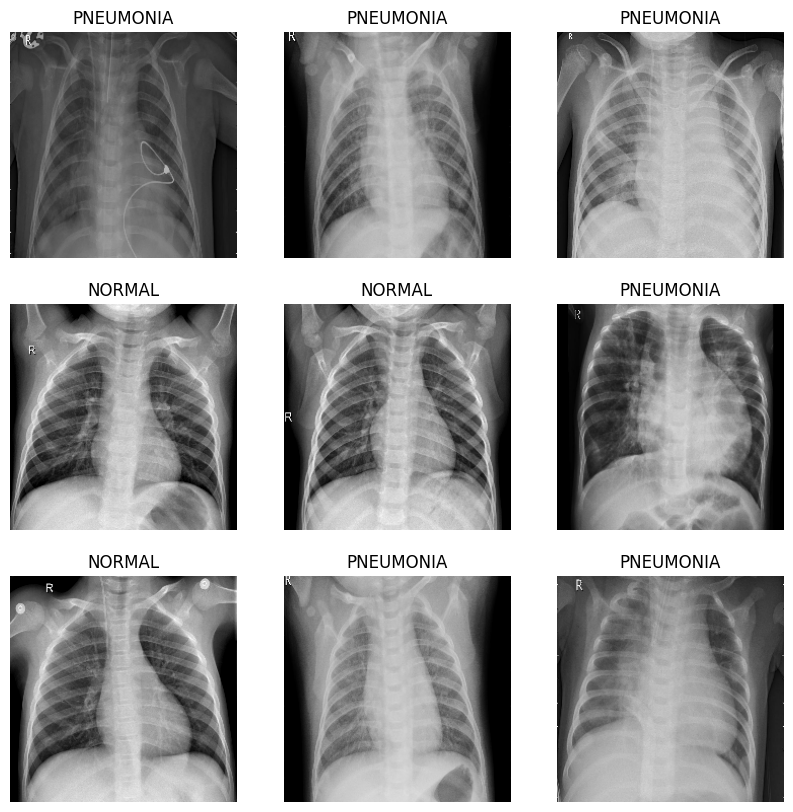

In [14]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
# Configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
# Data augmentation technique
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

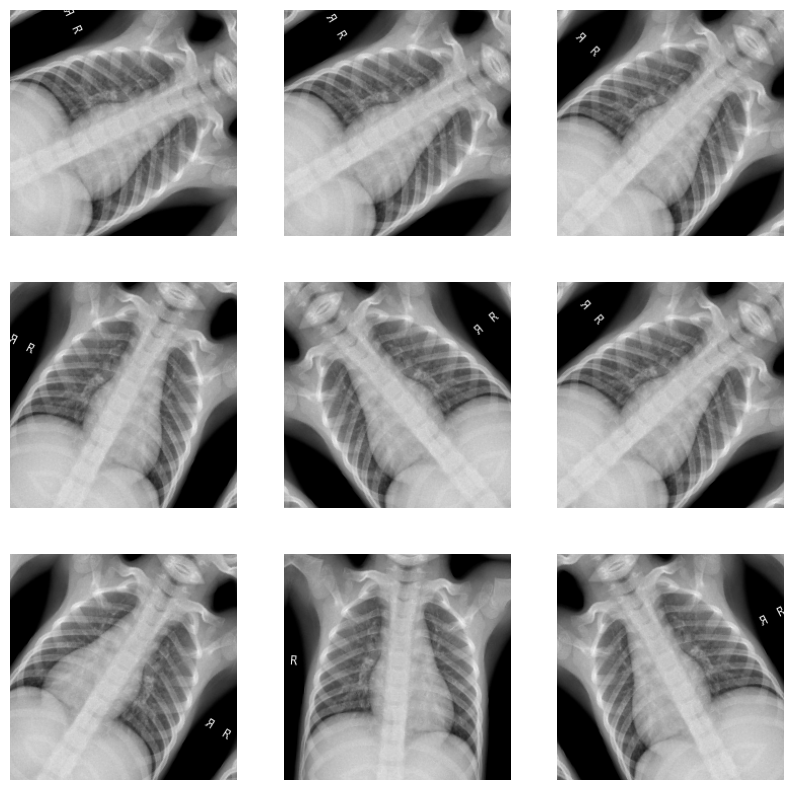

In [17]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [13]:
# Rescale Pixel values

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [15]:
# Instantiate the base model with the pre-trained model MobileNet V2
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

In [16]:
# See shape of the image after feature extraction
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


### Feature Extraction

In [17]:
# Freeze the base_model

base_model.trainable = False

In [18]:
# Base model architecture

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [19]:
# Add a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [21]:
#Train the top layer

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_3 = tf.keras.Model(inputs, outputs)

In [22]:
# Model summary

model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [23]:
len(model_3.trainable_variables)

2

tf.keras.utils.plot_model(
    model_3,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    #show_trainable=False
)

tf.keras.utils.plot_model(model_3, show_shapes=True)

## Compile the model

In [24]:
base_learning_rate = 0.0001
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
metrics=['accuracy'])

## Train the model

In [25]:
initial_epochs = 10
loss0, accuracy0 = model_3.evaluate(val_ds)

33/33 [==============================] - 13s 338ms/step - loss: 0.5492 - accuracy: 0.7199


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.55
initial accuracy: 0.72


In [27]:
history_3 = model_3.fit(train_ds,
                        epochs=initial_epochs,
                        validation_data=val_ds)

Epoch 1/10
131/131 [==============================] - 71s 498ms/step - loss: 0.5704 - accuracy: 0.6816 - val_loss: 0.4469 - val_accuracy: 0.7897
Epoch 2/10
131/131 [==============================] - 66s 499ms/step - loss: 0.4386 - accuracy: 0.8032 - val_loss: 0.3688 - val_accuracy: 0.8499
Epoch 3/10
131/131 [==============================] - 67s 507ms/step - loss: 0.3604 - accuracy: 0.8600 - val_loss: 0.3204 - val_accuracy: 0.8939
Epoch 4/10
131/131 [==============================] - 68s 517ms/step - loss: 0.3130 - accuracy: 0.8813 - val_loss: 0.2864 - val_accuracy: 0.9178
Epoch 5/10
131/131 [==============================] - 68s 518ms/step - loss: 0.2820 - accuracy: 0.8894 - val_loss: 0.2624 - val_accuracy: 0.9264
Epoch 6/10
131/131 [==============================] - 66s 499ms/step - loss: 0.2535 - accuracy: 0.9047 - val_loss: 0.2430 - val_accuracy: 0.9293
Epoch 7/10
131/131 [==============================] - 65s 490ms/step - loss: 0.2453 - accuracy: 0.9035 - val_loss: 0.2302 - val_ac

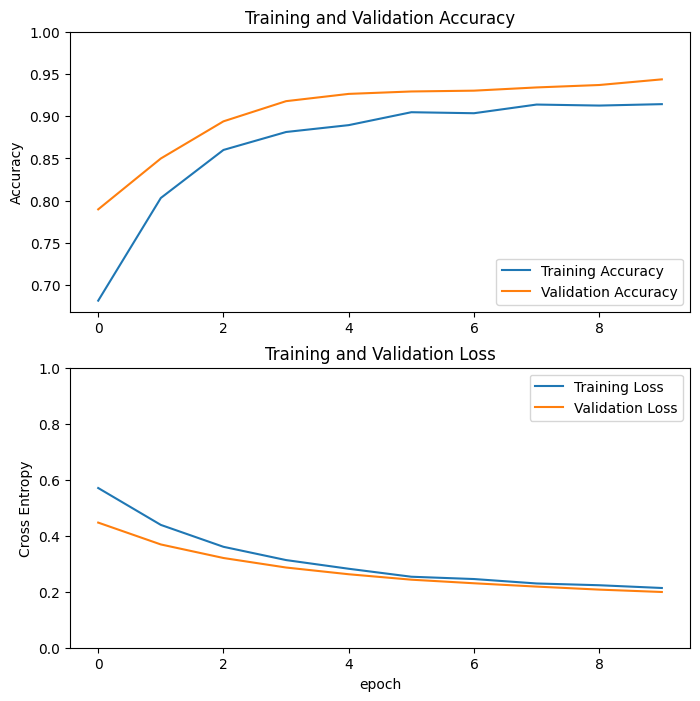

In [28]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine-tuning

In [29]:
# Un-freeze the top layers of the model

base_model.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
# Fine-tune from this layer onwards
fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


### Compile the model

In [31]:
model_3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[keras.metrics.BinaryAccuracy()])

In [32]:
model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [33]:
len(model_3.trainable_variables)

56

In [34]:
# Continue training the model
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model_3.fit(train_ds,
                           epochs=total_epochs,
                           initial_epoch=history_3.epoch[-1],
                           validation_data=val_ds)

Epoch 10/20
131/131 [==============================] - 96s 679ms/step - loss: 0.2213 - binary_accuracy: 0.9126 - val_loss: 0.0827 - val_binary_accuracy: 0.9675
Epoch 11/20
131/131 [==============================] - 89s 674ms/step - loss: 0.1075 - binary_accuracy: 0.9563 - val_loss: 0.0699 - val_binary_accuracy: 0.9780
Epoch 12/20
131/131 [==============================] - 92s 697ms/step - loss: 0.0901 - binary_accuracy: 0.9646 - val_loss: 0.0567 - val_binary_accuracy: 0.9742
Epoch 13/20
131/131 [==============================] - 80s 609ms/step - loss: 0.0736 - binary_accuracy: 0.9744 - val_loss: 0.0603 - val_binary_accuracy: 0.9732
Epoch 14/20
131/131 [==============================] - 88s 668ms/step - loss: 0.0669 - binary_accuracy: 0.9749 - val_loss: 0.0718 - val_binary_accuracy: 0.9646
Epoch 15/20
131/131 [==============================] - 84s 638ms/step - loss: 0.0632 - binary_accuracy: 0.9737 - val_loss: 0.0493 - val_binary_accuracy: 0.9818
Epoch 16/20
131/131 [===================

In [35]:
acc += history_fine.history['binary_accuracy']
val_acc += history_fine.history['val_binary_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

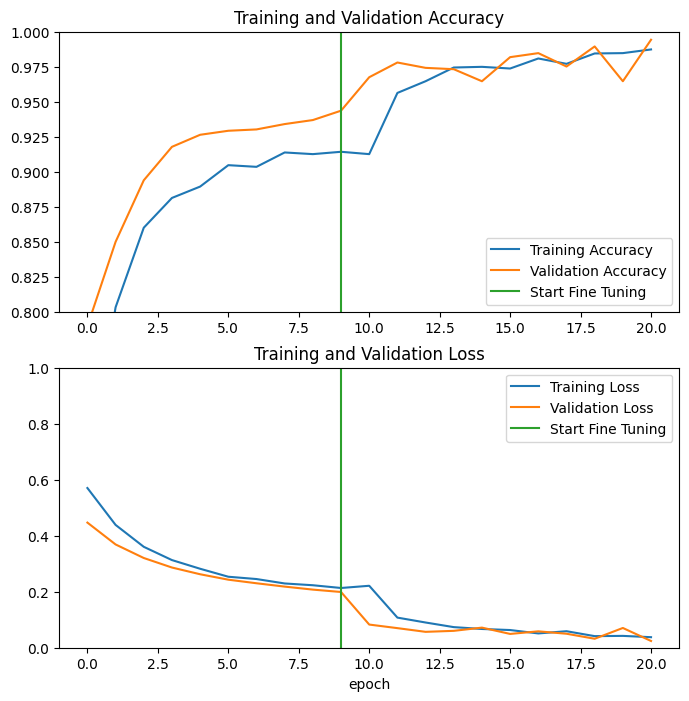

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and Prediction

In [37]:
#test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)
loss, accuracy = model_3.evaluate(test_ds)
print('Test accuracy :', accuracy)

20/20 [==============================] - 9s 381ms/step - loss: 0.8961 - binary_accuracy: 0.8253
Test accuracy : 0.8253205418586731


Predictions:
 [1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1]
Labels:
 [[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]]


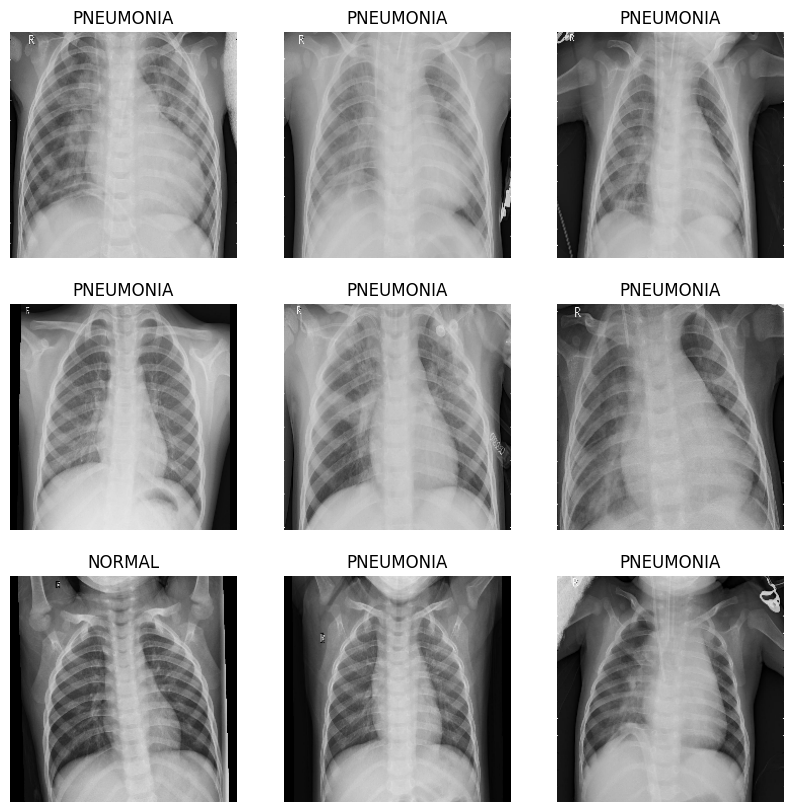

In [38]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model_3.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Tensorflow (2023). Transfer learning and fine-tuning. [online] TensorFlow. Available at: https://www.tensorflow.org/tutorials/images/transfer_learning#:~:text=A%20pre%2Dtrained%20model%20is,model%20to%20a%20given%20task. [Accessed 5 Sep. 2023].

In [39]:
# Print the classification report

print(classification_report(label_batch, predictions.numpy()))

              precision    recall  f1-score   support

         0.0       1.00      0.56      0.71         9
         1.0       0.85      1.00      0.92        23

    accuracy                           0.88        32
   macro avg       0.93      0.78      0.82        32
weighted avg       0.89      0.88      0.86        32



<Figure size 6000x6000 with 0 Axes>

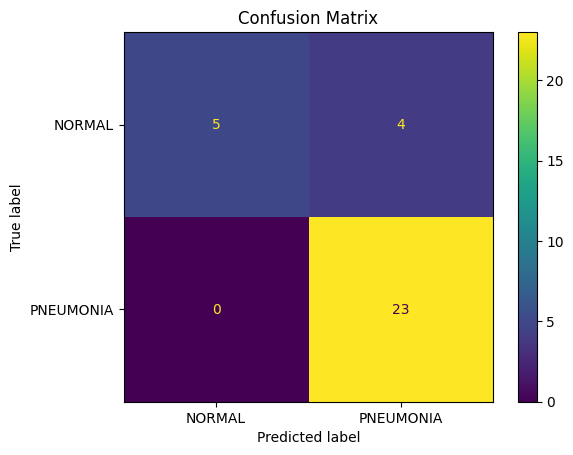

In [40]:
# Print the confusion matrix
plt.figure(dpi=200, figsize=(30,30))
cm = confusion_matrix(label_batch, predictions.numpy())
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
display.plot()
plt.title('Confusion Matrix')
plt.show()

## ResNet50 - Pretrained weights

In [4]:
# Split training sample

res_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size, 
    label_mode='int')

# Split validation sample

res_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size, 
    label_mode='int')

# Load the test sample

res_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, 
    image_size=(img_height, img_width),
    batch_size=batch_size, 
    label_mode='binary')

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


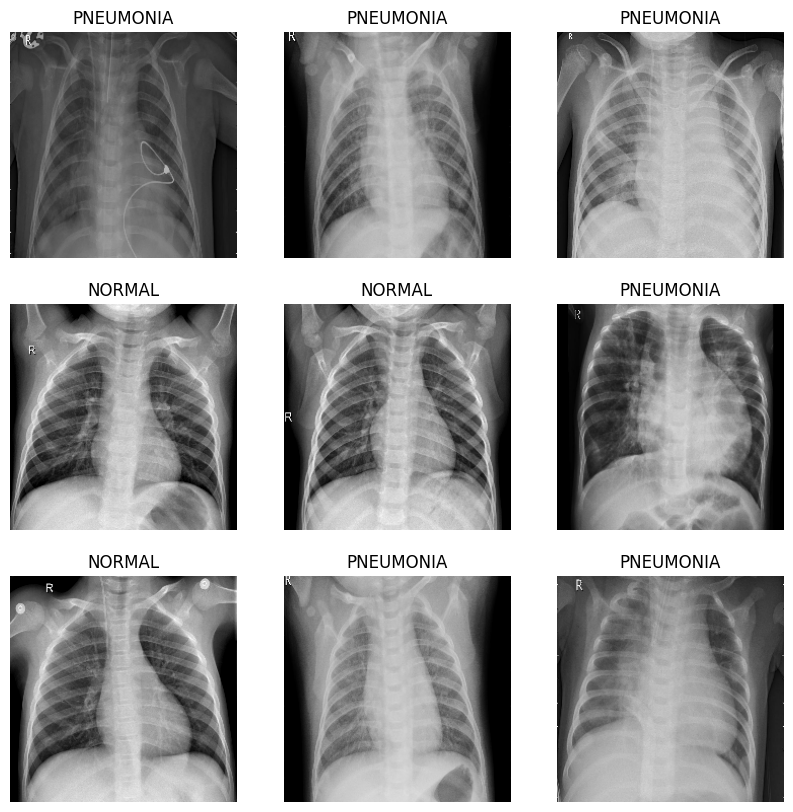

In [5]:
class_names = res_train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in res_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
# Configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE

res_train_ds = res_train_ds.prefetch(buffer_size=AUTOTUNE)
res_val_ds = res_val_ds.prefetch(buffer_size=AUTOTUNE)
res_test_ds = res_test_ds.prefetch(buffer_size=AUTOTUNE)

In [7]:
# Data augmentation technique
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

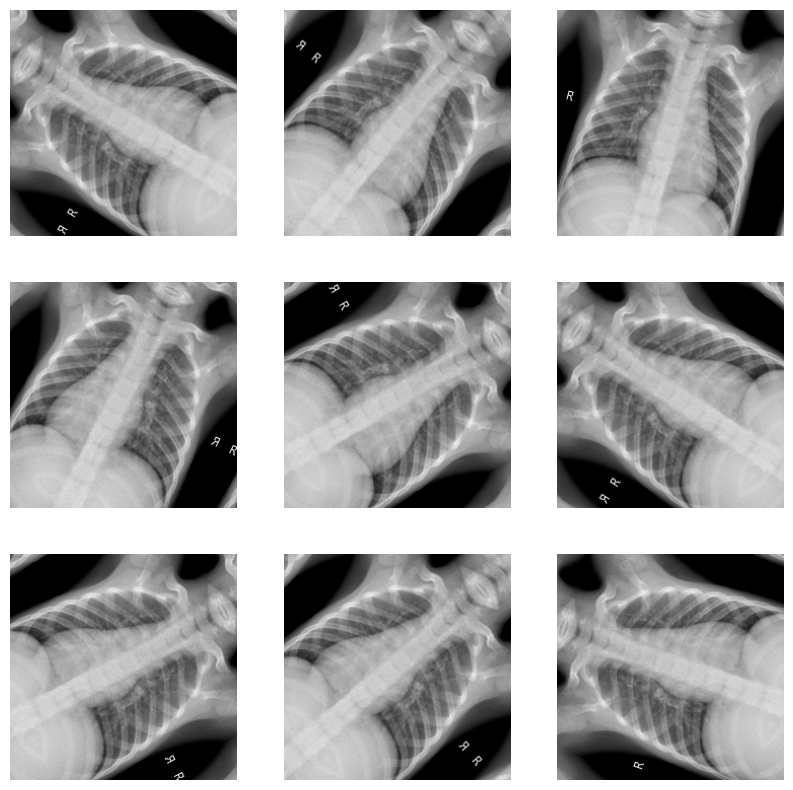

In [8]:
for image, _ in res_train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [9]:
# Rescale Pixel values

preprocess_input1 = tf.keras.applications.resnet50.preprocess_input

In [10]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [11]:
# Create the base model from the pre-trained model ResNet50
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model1 = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

In [12]:
image_batch, label_batch = next(iter(res_train_ds))
feature_batch = base_model1(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [13]:
base_model1.trainable = False

In [14]:
base_model1.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
#preprocess_input = tf.keras.applications.resnet50.preprocess_input

(32, 2048)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [17]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input1(x)
x = base_model1(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_4 = tf.keras.Model(inputs, outputs)

In [18]:
# Model summary

model_4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [19]:
len(model_4.trainable_variables)

2

### Compile the model

In [20]:
base_learning_rate = 0.0001
model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
metrics=['accuracy'])

In [21]:
#Train the model
initial_epochs = 10
loss0, accuracy0 = model_4.evaluate(res_val_ds)

33/33 [==============================] - 42s 1s/step - loss: 0.6187 - accuracy: 0.4914


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.62
initial accuracy: 0.49


In [23]:
history_4 = model_4.fit(res_train_ds,
                        epochs=initial_epochs,
                        validation_data=res_val_ds)

Epoch 1/10
131/131 [==============================] - 233s 2s/step - loss: 0.4741 - accuracy: 0.7628 - val_loss: 0.3035 - val_accuracy: 0.8891
Epoch 2/10
131/131 [==============================] - 238s 2s/step - loss: 0.3281 - accuracy: 0.8622 - val_loss: 0.2205 - val_accuracy: 0.9120
Epoch 3/10
131/131 [==============================] - 241s 2s/step - loss: 0.2575 - accuracy: 0.9004 - val_loss: 0.1893 - val_accuracy: 0.9120
Epoch 4/10
131/131 [==============================] - 239s 2s/step - loss: 0.2293 - accuracy: 0.9114 - val_loss: 0.1686 - val_accuracy: 0.9245
Epoch 5/10
131/131 [==============================] - 231s 2s/step - loss: 0.2096 - accuracy: 0.9193 - val_loss: 0.1539 - val_accuracy: 0.9283
Epoch 6/10
131/131 [==============================] - 228s 2s/step - loss: 0.2002 - accuracy: 0.9185 - val_loss: 0.1456 - val_accuracy: 0.9331
Epoch 7/10
131/131 [==============================] - 244s 2s/step - loss: 0.1882 - accuracy: 0.9207 - val_loss: 0.1375 - val_accuracy: 0.9321

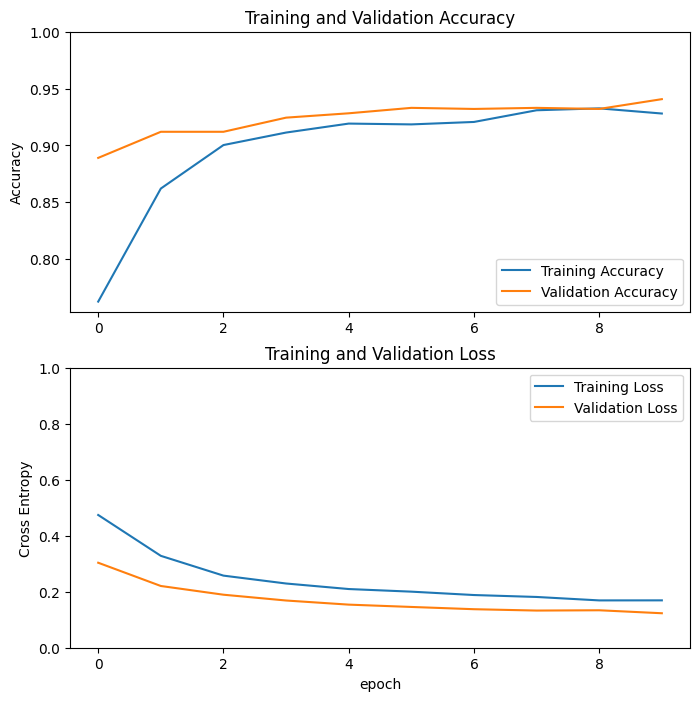

In [24]:
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']

loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine-tuning

In [25]:
#Un-freeze the top layers of the model
base_model1.trainable = True

In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model1.layers))
# Fine-tune from this layer onwards
fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model1.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  175


### Compile the model

In [27]:
model_4.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[keras.metrics.BinaryAccuracy()])

In [28]:
model_4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [29]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model_4.fit(res_train_ds,epochs=total_epochs,initial_epoch=history_4.epoch[-1],validation_data=res_val_ds)

Epoch 10/20
131/131 [==============================] - 416s 3s/step - loss: 0.2692 - binary_accuracy: 0.8925 - val_loss: 0.1478 - val_binary_accuracy: 0.9159
Epoch 11/20
131/131 [==============================] - 394s 3s/step - loss: 0.0954 - binary_accuracy: 0.9627 - val_loss: 0.0855 - val_binary_accuracy: 0.9541
Epoch 12/20
131/131 [==============================] - 389s 3s/step - loss: 0.0701 - binary_accuracy: 0.9720 - val_loss: 0.1233 - val_binary_accuracy: 0.9273
Epoch 13/20
131/131 [==============================] - 360s 3s/step - loss: 0.0595 - binary_accuracy: 0.9780 - val_loss: 0.0901 - val_binary_accuracy: 0.9560
Epoch 14/20
131/131 [==============================] - 338s 3s/step - loss: 0.0687 - binary_accuracy: 0.9730 - val_loss: 0.0752 - val_binary_accuracy: 0.9608
Epoch 15/20
131/131 [==============================] - 333s 3s/step - loss: 0.0540 - binary_accuracy: 0.9809 - val_loss: 0.1085 - val_binary_accuracy: 0.9465
Epoch 16/20
131/131 [==============================]

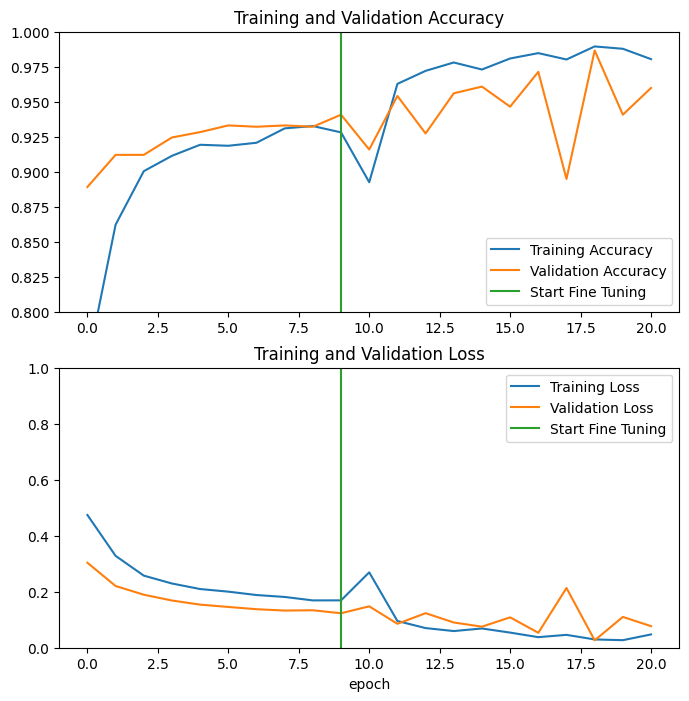

In [30]:
acc += history_fine.history['binary_accuracy']
val_acc += history_fine.history['val_binary_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and Prediction

In [31]:
loss, accuracy = model_4.evaluate(res_test_ds)
print('Test accuracy :', accuracy)

20/20 [==============================] - 25s 1s/step - loss: 0.4385 - binary_accuracy: 0.9038
Test accuracy : 0.9038461446762085


pred_1:
 [1 0 1 0 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 1]
Labels:
 [[1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]]


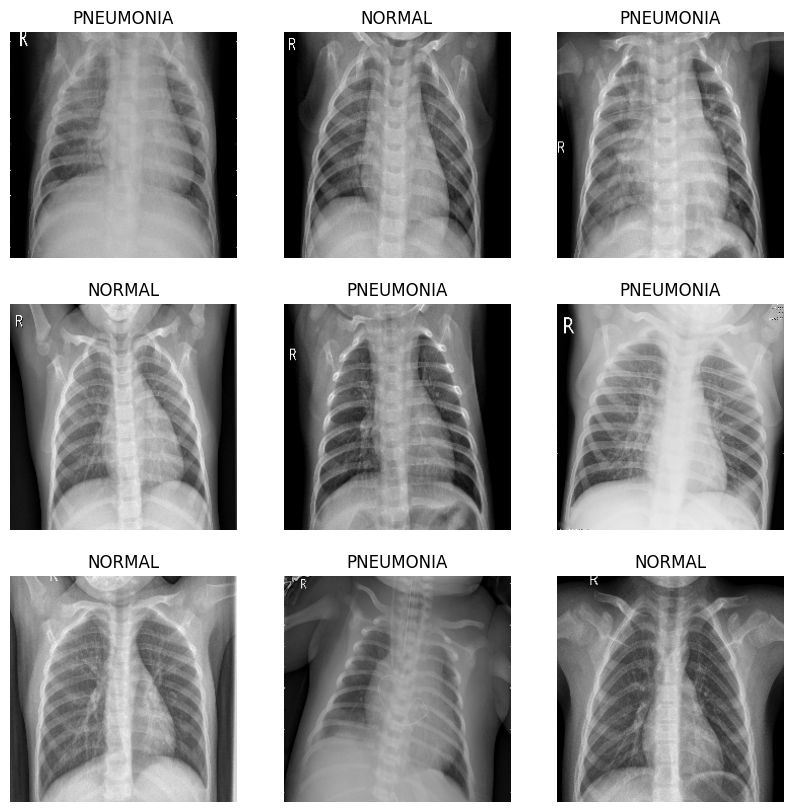

In [32]:
# Retrieve a batch of images from the test set
image_batch, label_batch = res_test_ds.as_numpy_iterator().next()
pred_1 = model_4.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
pred_1 = tf.nn.sigmoid(pred_1)
pred_1 = tf.where(pred_1 < 0.5, 0, 1)

print('pred_1:\n', pred_1.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[pred_1[i]])
  plt.axis("off")

In [33]:
# Print the classification report

print(classification_report(label_batch, pred_1.numpy()))

              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88        14
         1.0       0.86      1.00      0.92        18

    accuracy                           0.91        32
   macro avg       0.93      0.89      0.90        32
weighted avg       0.92      0.91      0.90        32



<Figure size 6000x6000 with 0 Axes>

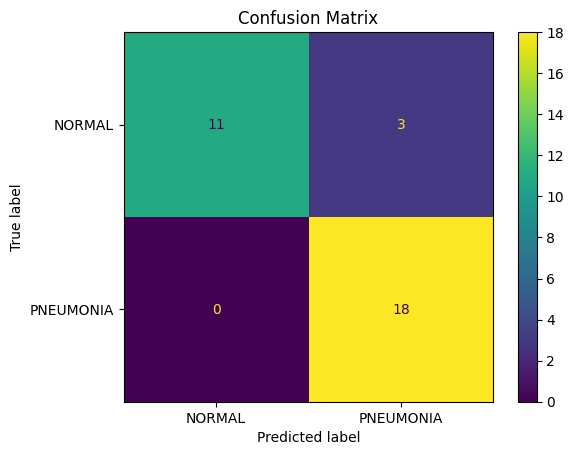

In [34]:
#Print the confusion matrix
plt.figure(dpi=200, figsize=(30,30))
cm = confusion_matrix(label_batch, pred_1.numpy())
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
display.plot()
plt.title('Confusion Matrix')
plt.show()

## DenseNet201

In [4]:
# Split training sample

res_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size, 
    label_mode='int')

# Split validation sample

res_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size, 
    label_mode='int')

# Load the test sample

res_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, 
    image_size=(img_height, img_width),
    batch_size=batch_size, 
    label_mode='binary')

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


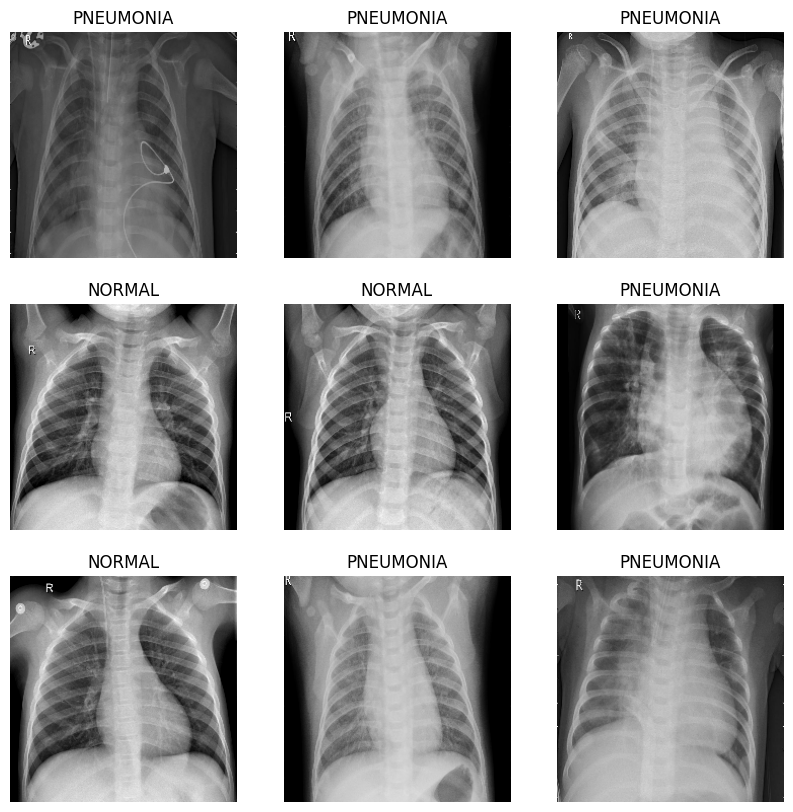

In [5]:
class_names = res_train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in res_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
# Configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE

res_train_ds = res_train_ds.prefetch(buffer_size=AUTOTUNE)
res_val_ds = res_val_ds.prefetch(buffer_size=AUTOTUNE)
res_test_ds = res_test_ds.prefetch(buffer_size=AUTOTUNE)

In [7]:
# Data augmentation technique
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

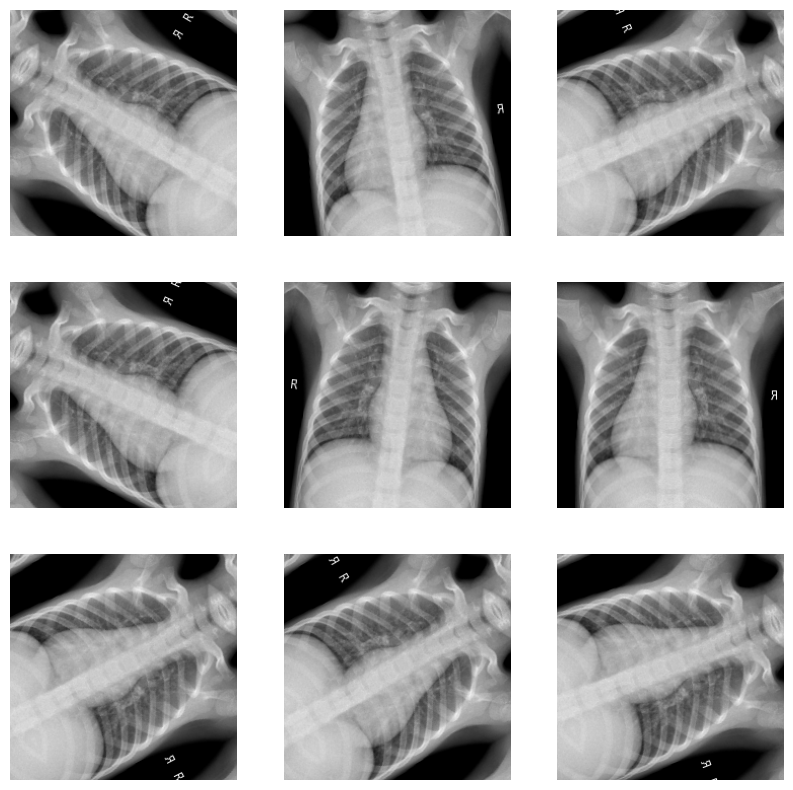

In [8]:
for image, _ in res_train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [9]:
# Rescale Pixel values

preprocess_input2 = tf.keras.applications.densenet.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [10]:
# Create the base model from the pre-trained model ResNet50
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model2 = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

In [11]:
image_batch, label_batch = next(iter(res_train_ds))
feature_batch = base_model2(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1920)


In [12]:
base_model2.trainable = False

In [13]:
base_model2.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 14, 14, 1024  4096       ['conv4_block24_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 14, 14, 1024  0          ['conv4_block25_0_bn[0][0]']     
 on)      

 lization)                      )                                                                 
                                                                                                  
 conv4_block29_0_relu (Activati  (None, 14, 14, 1152  0          ['conv4_block29_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 14, 14, 128)  147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block33_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block33_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 14, 14, 1312  0          ['conv4_block32_concat[0][0]',   
 ate)                           )                                 'conv4_block33_2_conv[0][0]']   
          

                                                                                                  
 conv4_block37_concat (Concaten  (None, 14, 14, 1440  0          ['conv4_block36_concat[0][0]',   
 ate)                           )                                 'conv4_block37_2_conv[0][0]']   
                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 14, 14, 1440  5760       ['conv4_block37_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 14, 14, 1440  0          ['conv4_block38_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_blo

 conv4_block42_0_relu (Activati  (None, 14, 14, 1568  0          ['conv4_block42_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block42_1_conv (Conv2D)  (None, 14, 14, 128)  200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block46_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block46_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 14, 14, 1728  0          ['conv4_block45_concat[0][0]',   
 ate)                           )                                 'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 14, 14, 1728  6912       ['conv4_block46_concat[0][0]']   
 lization)

                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 128)   512         ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 7, 7, 960)   0           ['conv5_block1_concat[0][0]',    
 te)      

 conv5_block6_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block6_1_relu[0][0]']    
                                                                                                  
 conv5_block6_concat (Concatena  (None, 7, 7, 1088)  0           ['conv5_block5_concat[0][0]',    
 te)                                                              'conv5_block6_2_conv[0][0]']    
                                                                                                  
 conv5_block7_0_bn (BatchNormal  (None, 7, 7, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 7, 7, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block11_0_relu (Activati  (None, 7, 7, 1216)  0           ['conv5_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_1_conv (Conv2D)  (None, 7, 7, 128)    155648      ['conv5_block11_0_relu[0][0]']   
                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block15_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 7, 7, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_blo

 conv5_block19_concat (Concaten  (None, 7, 7, 1504)  0           ['conv5_block18_concat[0][0]',   
 ate)                                                             'conv5_block19_2_conv[0][0]']   
                                                                                                  
 conv5_block20_0_bn (BatchNorma  (None, 7, 7, 1504)  6016        ['conv5_block19_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_0_relu (Activati  (None, 7, 7, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 7, 7, 128)    192512      ['conv5_block20_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv5_block24_1_conv (Conv2D)  (None, 7, 7, 128)    208896      ['conv5_block24_0_relu[0][0]']   
                                                                                                  
 conv5_block24_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block24_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

 conv5_block28_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block28_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block28_1_relu[0][0]']   
                                                                                                  
 conv5_block28_concat (Concaten  (None, 7, 7, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 7, 7, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 bn (BatchNormalization)        (None, 7, 7, 1920)   7680        ['conv5_block32_concat[0][0]']   
                                                                                                  
 relu (Activation)              (None, 7, 7, 1920)   0           ['bn[0][0]']                     
                                                                                                  
Total params: 18,321,984
Trainable params: 0
Non-trainable params: 18,321,984
__________________________________________________________________________________________________


In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1920)


In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [16]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input2(x)
x = base_model2(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_5 = tf.keras.Model(inputs, outputs)

In [17]:
# Model summary

model_5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        183219

In [18]:
len(model_5.trainable_variables)

2

### Compile the model

In [19]:
base_learning_rate = 0.0001
model_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
metrics=['accuracy'])

In [20]:
#Train the model
initial_epochs = 10
loss0, accuracy0 = model_5.evaluate(res_val_ds)

33/33 [==============================] - 56s 1s/step - loss: 0.6195 - accuracy: 0.3700


In [21]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.62
initial accuracy: 0.37


In [22]:
history_5 = model_5.fit(res_train_ds,
                        epochs=initial_epochs,
                        validation_data=res_val_ds)

Epoch 1/10
131/131 [==============================] - 313s 2s/step - loss: 0.5348 - accuracy: 0.7169 - val_loss: 0.4765 - val_accuracy: 0.6912
Epoch 2/10
131/131 [==============================] - 304s 2s/step - loss: 0.4375 - accuracy: 0.8151 - val_loss: 0.4271 - val_accuracy: 0.7342
Epoch 3/10
131/131 [==============================] - 283s 2s/step - loss: 0.3773 - accuracy: 0.8481 - val_loss: 0.3649 - val_accuracy: 0.8145
Epoch 4/10
131/131 [==============================] - 311s 2s/step - loss: 0.3192 - accuracy: 0.8894 - val_loss: 0.3433 - val_accuracy: 0.8203
Epoch 5/10
131/131 [==============================] - 337s 3s/step - loss: 0.2943 - accuracy: 0.8958 - val_loss: 0.2986 - val_accuracy: 0.8614
Epoch 6/10
131/131 [==============================] - 300s 2s/step - loss: 0.2688 - accuracy: 0.9047 - val_loss: 0.2836 - val_accuracy: 0.8671
Epoch 7/10
131/131 [==============================] - 250s 2s/step - loss: 0.2481 - accuracy: 0.9173 - val_loss: 0.2567 - val_accuracy: 0.8824

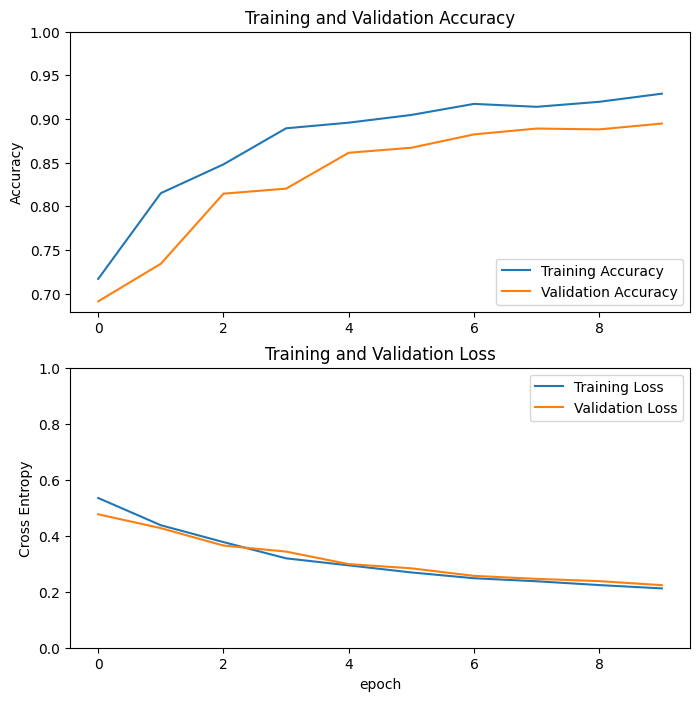

In [23]:
acc = history_5.history['accuracy']
val_acc = history_5.history['val_accuracy']

loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
#Un-freeze the top layers of the model
base_model2.trainable = True

In [25]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model2.layers))
# Fine-tune from this layer onwards
fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model2.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  707


In [26]:
model_5.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[keras.metrics.BinaryAccuracy()])

In [27]:
model_5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        183219

In [28]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model_5.fit(res_train_ds,epochs=total_epochs,initial_epoch=history_5.epoch[-1],validation_data=res_val_ds)

Epoch 10/20
131/131 [==============================] - 653s 5s/step - loss: 0.3311 - binary_accuracy: 0.8684 - val_loss: 0.5169 - val_binary_accuracy: 0.7017
Epoch 11/20
131/131 [==============================] - 645s 5s/step - loss: 0.1480 - binary_accuracy: 0.9398 - val_loss: 0.1056 - val_binary_accuracy: 0.9455
Epoch 12/20
131/131 [==============================] - 645s 5s/step - loss: 0.0974 - binary_accuracy: 0.9611 - val_loss: 0.0944 - val_binary_accuracy: 0.9446
Epoch 13/20
131/131 [==============================] - 661s 5s/step - loss: 0.0666 - binary_accuracy: 0.9752 - val_loss: 0.0488 - val_binary_accuracy: 0.9732
Epoch 14/20
131/131 [==============================] - 705s 5s/step - loss: 0.0696 - binary_accuracy: 0.9742 - val_loss: 0.0624 - val_binary_accuracy: 0.9627
Epoch 15/20
131/131 [==============================] - 718s 5s/step - loss: 0.0601 - binary_accuracy: 0.9778 - val_loss: 0.0513 - val_binary_accuracy: 0.9704
Epoch 16/20
131/131 [==============================]

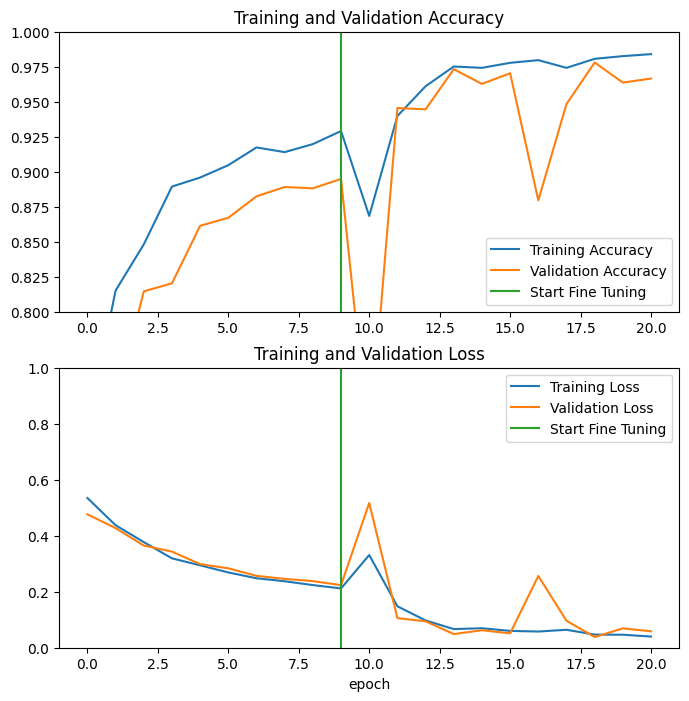

In [29]:
acc += history_fine.history['binary_accuracy']
val_acc += history_fine.history['val_binary_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
loss, accuracy = model_5.evaluate(res_test_ds)
print('Test accuracy :', accuracy)

20/20 [==============================] - 96s 2s/step - loss: 0.3832 - binary_accuracy: 0.8958
Test accuracy : 0.8958333134651184


pred_1:
 [0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1]
Labels:
 [[0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]]


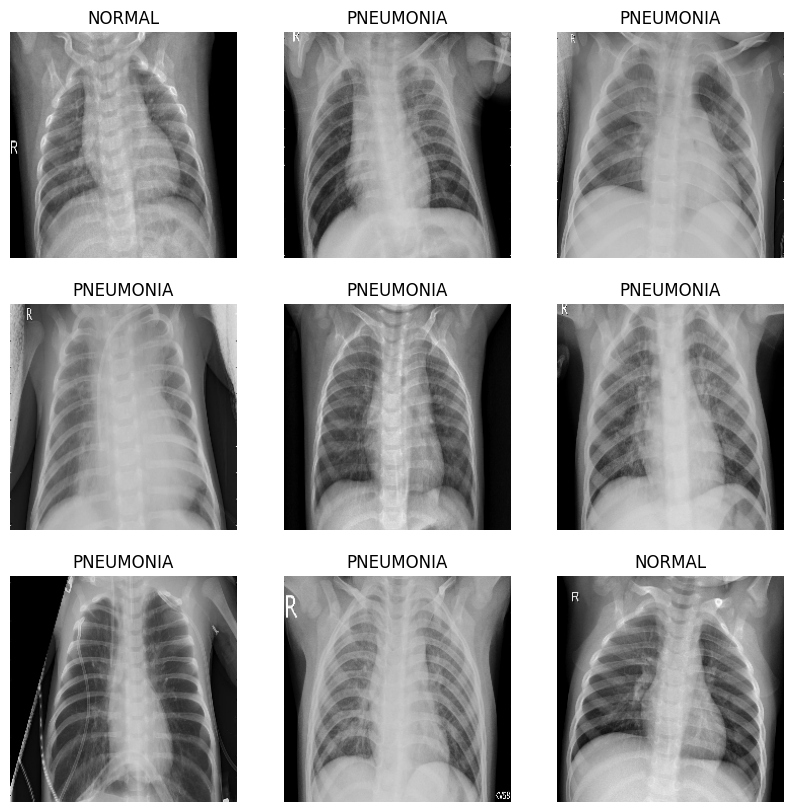

In [31]:
# Retrieve a batch of images from the test set
image_batch, label_batch = res_test_ds.as_numpy_iterator().next()
pred_2 = model_5.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
pred_2 = tf.nn.sigmoid(pred_2)
pred_2 = tf.where(pred_2 < 0.5, 0, 1)

print('pred_1:\n', pred_2.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[pred_2[i]])
  plt.axis("off")

In [32]:
# Print the classification report

print(classification_report(label_batch, pred_2.numpy()))

              precision    recall  f1-score   support

         0.0       1.00      0.60      0.75        10
         1.0       0.85      1.00      0.92        22

    accuracy                           0.88        32
   macro avg       0.92      0.80      0.83        32
weighted avg       0.89      0.88      0.86        32



<Figure size 6000x6000 with 0 Axes>

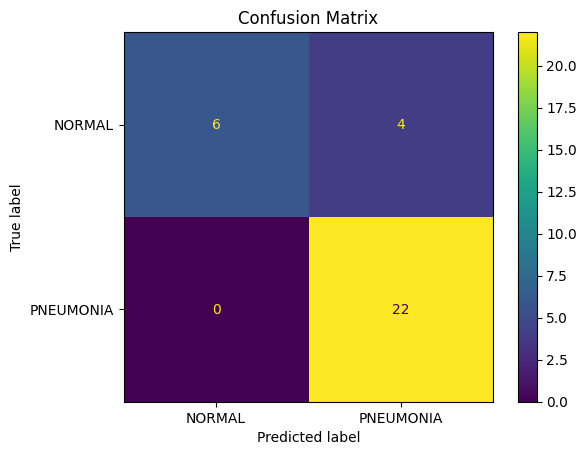

In [33]:
#Print the confusion matrix
plt.figure(dpi=200, figsize=(30,30))
cm = confusion_matrix(label_batch, pred_2.numpy())
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
display.plot()
plt.title('Confusion Matrix')
plt.show()

## VGG-19

In [36]:
# Split training sample

res_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size, 
    label_mode='int')

# Split validation sample

res_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size, 
    label_mode='int')

# Load the test sample

res_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, 
    image_size=(img_height, img_width),
    batch_size=batch_size, 
    label_mode='binary')

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


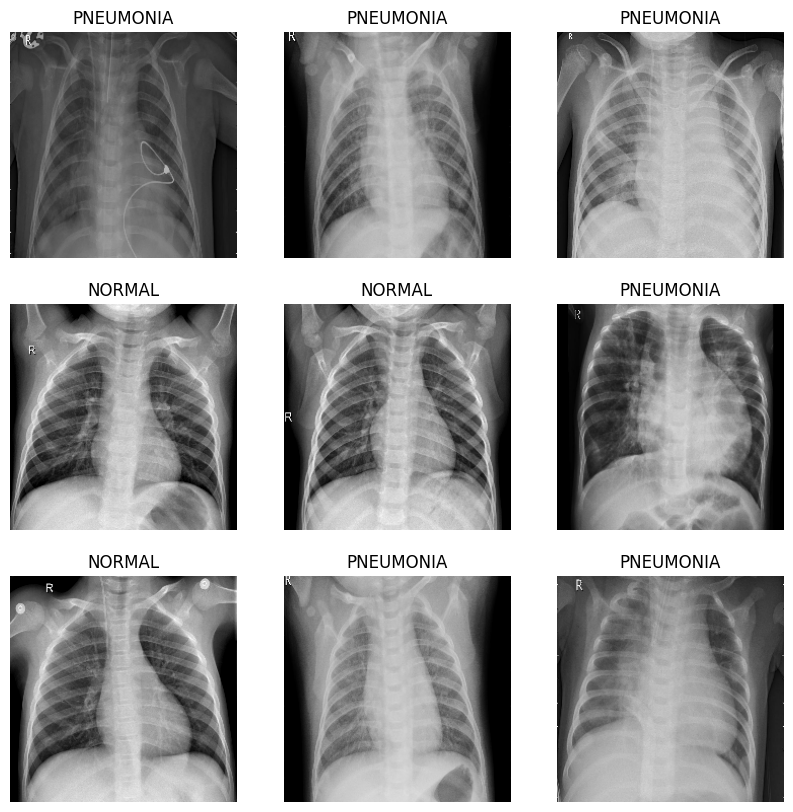

In [37]:
class_names = res_train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in res_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [38]:
# Configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE

res_train_ds = res_train_ds.prefetch(buffer_size=AUTOTUNE)
res_val_ds = res_val_ds.prefetch(buffer_size=AUTOTUNE)
res_test_ds = res_test_ds.prefetch(buffer_size=AUTOTUNE)

In [39]:
# Data augmentation technique
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

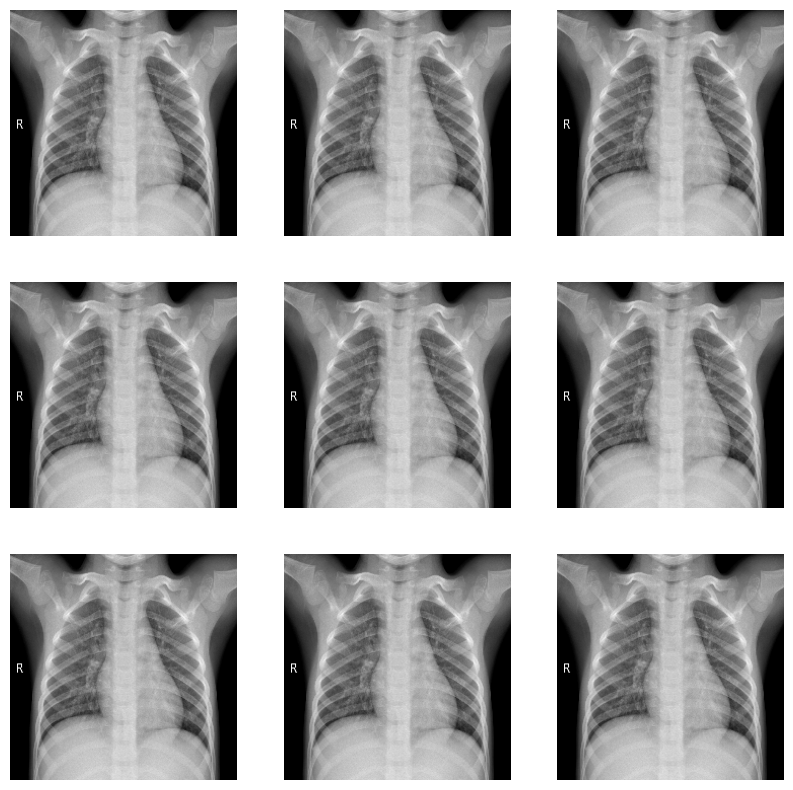

In [40]:
for image, _ in res_train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [41]:
# Rescale Pixel values

preprocess_input3 = tf.keras.applications.vgg19.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [43]:
# Create the base model from the pre-trained model ResNet50
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model3 = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

80134624/80134624 [==============================] - 8s 0us/step


In [44]:
image_batch, label_batch = next(iter(res_train_ds))
feature_batch = base_model3(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


In [45]:
base_model2.trainable = False

In [46]:
base_model3.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [47]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [48]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [49]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input3(x)
x = base_model3(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_6 = tf.keras.Model(inputs, outputs)

In [50]:
# Model summary

model_6.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0   

In [52]:
len(model_6.trainable_variables)

34

### Compile the model

In [53]:
base_learning_rate = 0.0001
model_6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
metrics=['accuracy'])

In [54]:
#Train the model
initial_epochs = 10
loss0, accuracy0 = model_6.evaluate(res_val_ds)

33/33 [==============================] - 169s 5s/step - loss: 2.2052 - accuracy: 0.2811


In [55]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.21
initial accuracy: 0.28


In [56]:
history_6 = model_6.fit(res_train_ds,
                        epochs=initial_epochs,
                        validation_data=res_val_ds)

Epoch 1/10
131/131 [==============================] - 3117s 24s/step - loss: 0.6953 - accuracy: 0.5547 - val_loss: 0.4365 - val_accuracy: 0.8633
Epoch 2/10
131/131 [==============================] - 3032s 23s/step - loss: 0.3891 - accuracy: 0.7974 - val_loss: 0.5513 - val_accuracy: 0.6128
Epoch 3/10
131/131 [==============================] - 3030s 23s/step - loss: 0.2818 - accuracy: 0.8813 - val_loss: 0.3413 - val_accuracy: 0.7916
Epoch 4/10
131/131 [==============================] - 3211s 25s/step - loss: 0.2414 - accuracy: 0.8992 - val_loss: 0.3185 - val_accuracy: 0.8078
Epoch 5/10
131/131 [==============================] - 3333s 25s/step - loss: 0.2201 - accuracy: 0.9109 - val_loss: 0.2719 - val_accuracy: 0.8604
Epoch 6/10
131/131 [==============================] - 3018s 23s/step - loss: 0.1945 - accuracy: 0.9240 - val_loss: 0.2646 - val_accuracy: 0.8432
Epoch 7/10
131/131 [==============================] - 2935s 22s/step - loss: 0.1683 - accuracy: 0.9362 - val_loss: 0.1766 - val_ac

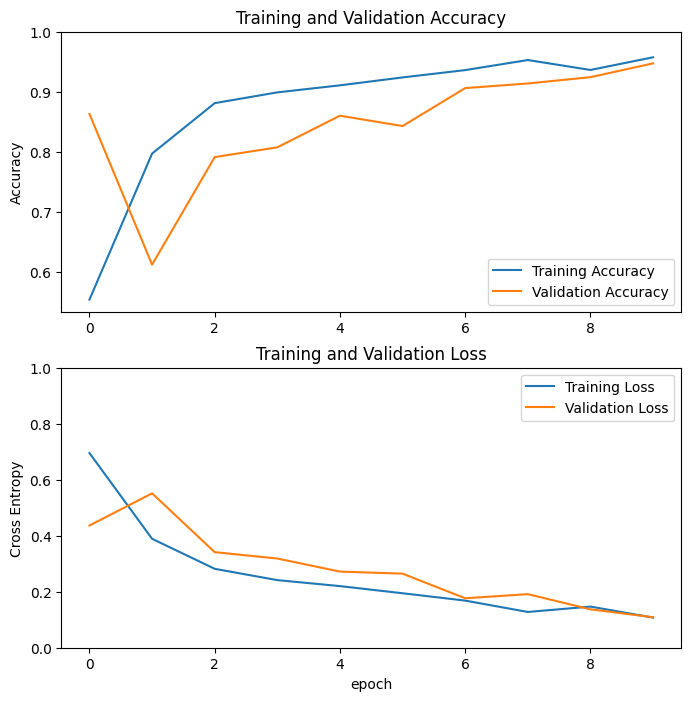

In [57]:
acc = history_6.history['accuracy']
val_acc = history_6.history['val_accuracy']

loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine-tuning

In [58]:
#Un-freeze the top layers of the model
base_model3.trainable = True

In [59]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model3.layers))
# Fine-tune from this layer onwards
fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model3.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  22


### Compile the model

In [60]:
model_6.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[keras.metrics.BinaryAccuracy()])

In [61]:
model_6.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0   

In [62]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model_6.fit(res_train_ds,epochs=total_epochs,initial_epoch=history_6.epoch[-1],validation_data=res_val_ds)

Epoch 10/20
131/131 [==============================] - 878s 6s/step - loss: 0.0681 - binary_accuracy: 0.9766 - val_loss: 0.1302 - val_binary_accuracy: 0.9398
Epoch 11/20
131/131 [==============================] - 838s 6s/step - loss: 0.0677 - binary_accuracy: 0.9768 - val_loss: 0.1398 - val_binary_accuracy: 0.9369
Epoch 12/20
131/131 [==============================] - 838s 6s/step - loss: 0.0662 - binary_accuracy: 0.9763 - val_loss: 0.1447 - val_binary_accuracy: 0.9359
Epoch 13/20
131/131 [==============================] - 836s 6s/step - loss: 0.0650 - binary_accuracy: 0.9766 - val_loss: 0.1460 - val_binary_accuracy: 0.9359
Epoch 14/20
131/131 [==============================] - 835s 6s/step - loss: 0.0604 - binary_accuracy: 0.9763 - val_loss: 0.1492 - val_binary_accuracy: 0.9359
Epoch 15/20
131/131 [==============================] - 837s 6s/step - loss: 0.0674 - binary_accuracy: 0.9747 - val_loss: 0.1494 - val_binary_accuracy: 0.9359
Epoch 16/20
131/131 [==============================]

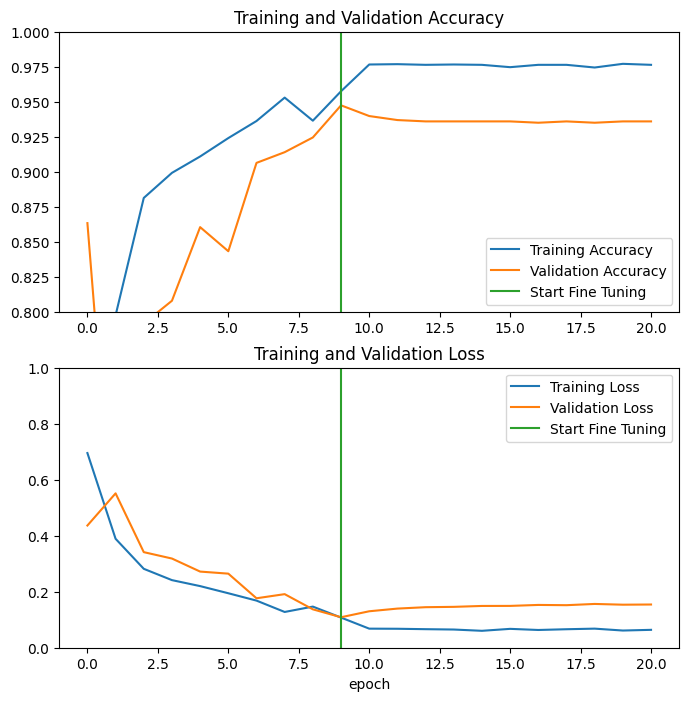

In [63]:
acc += history_fine.history['binary_accuracy']
val_acc += history_fine.history['val_binary_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and Prediction

In [64]:
loss, accuracy = model_6.evaluate(res_test_ds)
print('Test accuracy :', accuracy)

20/20 [==============================] - 113s 5s/step - loss: 0.3820 - binary_accuracy: 0.8718
Test accuracy : 0.8717948794364929


pred_3:
 [1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1 1 1]
Labels:
 [[1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]]


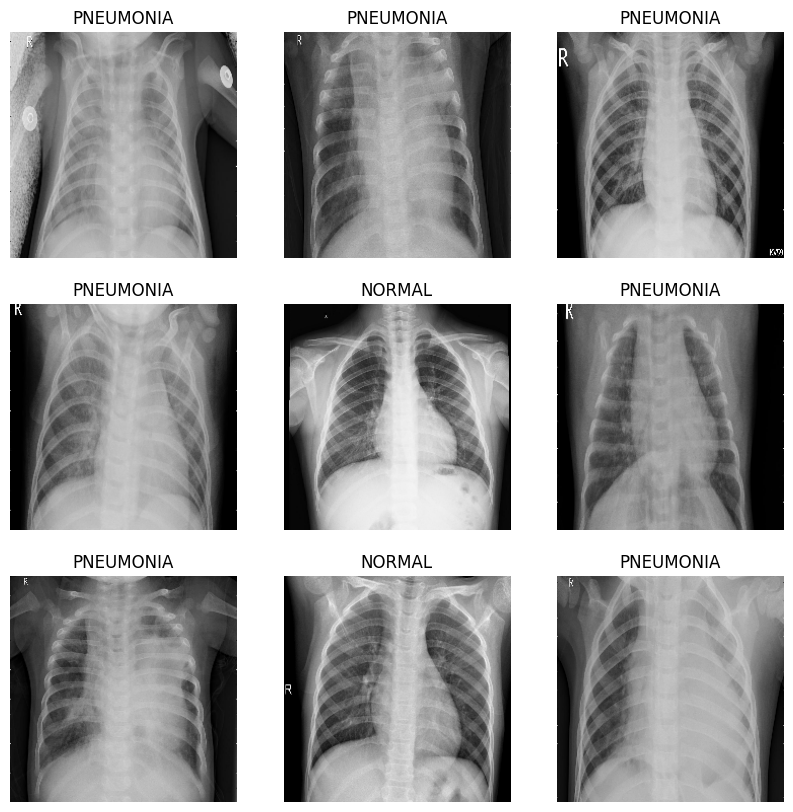

In [65]:
# Retrieve a batch of images from the test set
image_batch, label_batch = res_test_ds.as_numpy_iterator().next()
pred_3 = model_6.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
pred_3 = tf.nn.sigmoid(pred_3)
pred_3 = tf.where(pred_3 < 0.5, 0, 1)

print('pred_3:\n', pred_3.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[pred_3[i]])
  plt.axis("off")

In [66]:
# Print the classification report

print(classification_report(label_batch, pred_3.numpy()))

              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89        15
         1.0       0.85      1.00      0.92        17

    accuracy                           0.91        32
   macro avg       0.93      0.90      0.90        32
weighted avg       0.92      0.91      0.90        32



<Figure size 6000x6000 with 0 Axes>

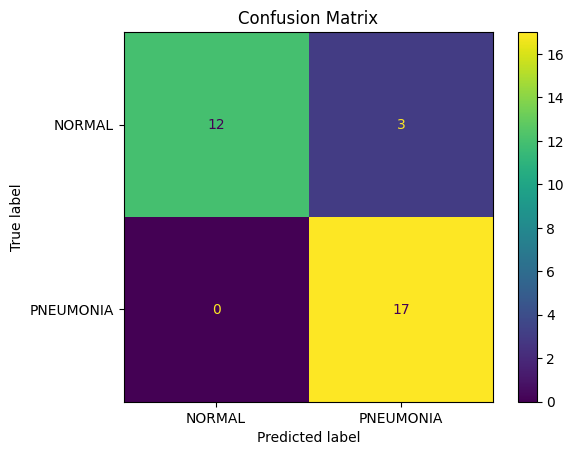

In [67]:
#Print the confusion matrix
plt.figure(dpi=200, figsize=(30,30))
cm = confusion_matrix(label_batch, pred_3.numpy())
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
display.plot()
plt.title('Confusion Matrix')
plt.show()

In [55]:
# Create Main Title
Metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

# Other Title
Pretrained_Networks = ['Proposed Model', 'MobileNetV2', 'ResNet50', 
                       'DenseNet201', 'VGG-19']

# Create Input Values
values = [[0.90, 0.90, 0.90, 0.91], [0.93, 0.78, 0.82, 0.88], 
          [0.93, 0.89, 0.90, 0.91], [0.92, 0.80, 0.83, 0.88], 
          [0.93, 0.90, 0.90, 0.91]]

# Transform to a dataframe
Pretrained = pd.DataFrame(values, Pretrained_Networks, Metrics)
Pretrained

Precision  Recall  F1-Score  Accuracy
Proposed Model       0.90    0.90      0.90      0.91
MobileNetV2          0.93    0.78      0.82      0.88
ResNet50             0.93    0.89      0.90      0.91
DenseNet201          0.92    0.80      0.83      0.88
VGG-19               0.93    0.90      0.90      0.91

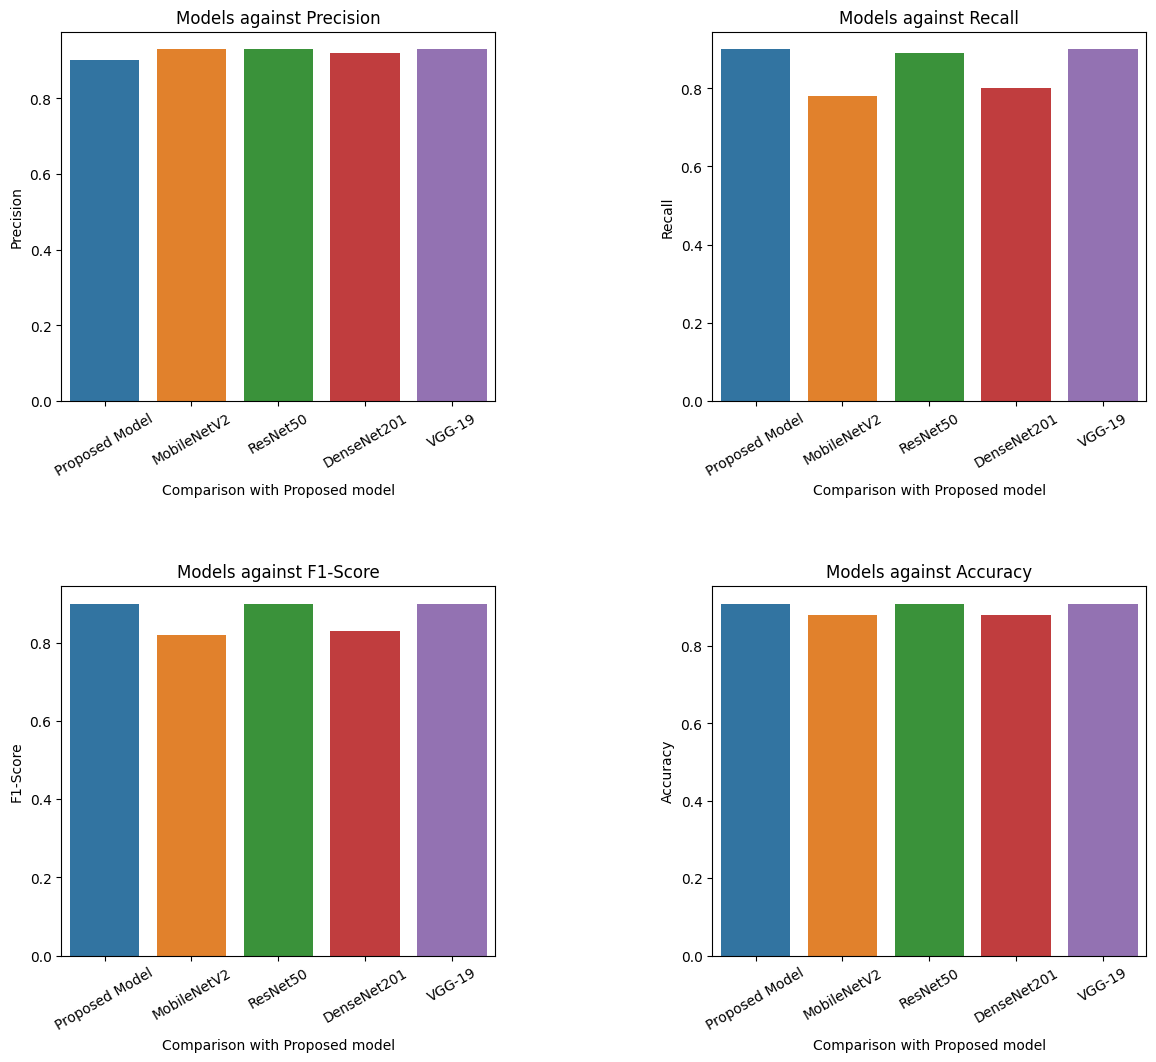

In [65]:
#Graph of Models against Evaluation Metrics
rcParams['figure.figsize'] = 14, 12

#subplot 1
plt.subplot(2,2,1)
#Create a plot of Models against Precision
sns.barplot(data=Pretrained, y='Precision', x=Pretrained_Networks)
plt.title('Models against Precision')
plt.xlabel('Comparison with Proposed model')
plt.ylabel('Precision')
plt.xticks(rotation=30);

#subplot 2
plt.subplot(2,2,2)
#Create a plot of Models against Recall
sns.barplot(data=Pretrained, y='Recall', x=Pretrained_Networks)
plt.title('Models against Recall')
plt.xlabel('Comparison with Proposed model')
plt.ylabel('Recall')
plt.xticks(rotation=30);

#subplot 3
plt.subplot(2,2,3)
#Create a plot of Models against F1-Score
sns.barplot(data=Pretrained, y='F1-Score', x=Pretrained_Networks)
plt.title('Models against F1-Score')
plt.xlabel('Comparison with Proposed model')
plt.ylabel('F1-Score')
plt.xticks(rotation=30);

#subplot 4
plt.subplot(2,2,4)
#Create a plot of Models against Accuracy
sns.barplot(data=Pretrained, y='Accuracy', x=Pretrained_Networks)
plt.title('Models against Accuracy')
plt.xlabel('Comparison with Proposed model')
plt.ylabel('Accuracy')
plt.xticks(rotation=30);

plt.subplots_adjust(wspace=0.50, 
                    hspace=0.5)